In [ ]:

# Note: This notebook runs locally with using NVIDIA RTX-4090 GPU (24G)

In [102]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Create multiple databases simulating scenarios with scarse data

Create multiple instances of classification problems simulating scarse data:

In [ ]:
from itertools import combinations

def combinations_n_m(n: int, m: int) -> list[list[int]]:
    """
    Generate all combinations of the integers 1..n taken m at a time.

    Parameters:
        n (int): The size of the set (1 through n).
        m (int): The number of elements in each combination.

    Returns:
        List of combinations, where each combination is itself a list of ints.
    """
    # itertools.combinations yields tuples, so we convert each to a list
    return [list(c) for c in combinations(range(1, n + 1), m)]

In [15]:
from itertools import combinations
import os
import shutil
import random
from pathlib import Path


def clear_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Borra archivos y enlaces simbólicos
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Borra subcarpetas y su contenido
        except Exception as e:
            print(f'Error al borrar {file_path}. Detalle: {e}')

def create_mixed_folders(
    src1: str,
    src2: str,
    src3: str,
    dest1: str,
    dest2: str,
    dest3: str,
    k1: int,
    k2: int,
    k3: int,
    seed: int
):
    """
    src1, src2, src3: paths to your original folders
    dest1, dest2, dest3: paths to new folders to create
    k1: how many random files from src2+src3 to add into dest1 (on top of all src1 files)
    k2: how many random files from the REMAINING pool to put into dest2
    k3: how many random files from what's left to put into dest3
    
    All random draws are WITHOUT replacement, so dest1, dest2, dest3 sets
    are pairwise disjoint apart from the fact that dest1 also contains ALL of src1.
    """
    random.seed(seed)
    
    # 1) Gather file lists
    files1 = [Path(src1) / f for f in os.listdir(src1) if (Path(src1)/f).is_file()]
    pool23 = [Path(src2)/f for f in os.listdir(src2) if (Path(src2)/f).is_file()] \
           + [Path(src3)/f for f in os.listdir(src3) if (Path(src3)/f).is_file()]

    
    
    total_needed = k1 + k2 + k3
    if total_needed > len(pool23):
        raise ValueError(f"Not enough files in src2+src3 ({len(pool23)}) to sample {total_needed} unique files.")
    
    # 2) Sample without replacement
    if k1>1:
        sample1 = set(random.sample(pool23, k1))
        remaining = list(set(pool23) - sample1)
    else:
        remaining = list(set(pool23))
    sample2 = set(random.sample(remaining, k2))
    remaining2 = list(set(remaining) - sample2)
    sample3 = set(random.sample(remaining2, k3))

    # 3) Create dest folders
    for d in (dest1, dest2, dest3):
        os.makedirs(d, exist_ok=True)
        clear_folder(d)
    
    # 4) Copy files into dest1: all of src1 + sample1
    for src_path in files1:
        shutil.copy2(src_path, Path(dest1)/src_path.name)
    if k1>0:
        for src_path in sample1:
            shutil.copy2(src_path, Path(dest1)/src_path.name)
    
    # 5) Copy sample2 into dest2, sample3 into dest3
    for src_path in sample2:
        shutil.copy2(src_path, Path(dest2)/src_path.name)
    for src_path in sample3:
        shutil.copy2(src_path, Path(dest3)/src_path.name)
    


def combinations_n_m(n: int, m: int) -> list[list[int]]:
    """
    Generate all combinations of the integers 1..n taken m at a time.

    Parameters:
        n (int): The size of the set (1 through n).
        m (int): The number of elements in each combination.

    Returns:
        List of combinations, where each combination is itself a list of ints.
    """
    # itertools.combinations yields tuples, so we convert each to a list
    return [list(c) for c in combinations(range(1, n + 1), m)]

# Original distribution of data
#samples_config_nored = {
#"s1":(	137	,	31	,	21	),
#"s2":(	197	,	43	,	29	),
#"s3":(	107	,	25	,	17	),
#"s4":(	22	,	8	,	5	),
#"s5":(	41	,	12	,	8	),
#"s6":(	21	,	8	,	5	),
#"s7":(	47	,	13	,	9	),
#"s8":(	171	,	38	,	25	),
#"s9":(	120	,	28	,	18	)
#}

# Data used for constructing the scarse DBs
samples_config_nored = {
"s1":(	137	,	52	,	0	),
"s2":(	197	,	72	,	0	),
"s3":(	107	,	42	,	0	),
"s4":(	22	,	13	,	0	),
"s5":(	41	,	20	,	0	),
"s6":(	21	,	13	,	0	),
"s7":(	47	,	21	,	0	),
"s8":(	171	,	63	,	0	),
"s9":(	120	,	46	,	0	)
}

pathReducedDB = "C:/Users/user/Documents/soundDBAugmented/train_val_test_fulldb"
pathDestDB = "C:/Users/user/Documents/soundDBAugmented/classification_exp_adj/"


# Create multiple instances of DBs with scarse data by reducing the number of samples of some selected classes
# Classes resulted from running different combinations, namely, 9 combined 1, 9 combined 2, 9 combined 3
n, m = 9, 3
combs = combinations_n_m(n, m)
seedDB = 2


for comb in combs:
  print('------------')
  idexp = "expe_" + "_".join(map(str, comb))
  print(idexp)
  for i in range(n):
    idclass = "s"+str(i+1)
    src1 = pathReducedDB+"/train/"+idclass
    src2 = pathReducedDB+"/validation/"+idclass
    src3 = pathReducedDB+"/test/"+idclass
    dest1 = pathDestDB + idexp+"/train/"+idclass
    dest2 = pathDestDB + idexp+"/validation/"+idclass
    dest3 = pathDestDB + idexp+"/test/"+idclass

    if (i + 1) in comb:
      #print('use the subsample dataset')
      #print(idclass)
      #print(samples_config[idclass])
      sizeTrain = 0
    else:
      #print('use the original training data')
      #print(idclass)
      #print(samples_config_nored[idclass])
      sizeTrain = samples_config_nored[idclass][0]
    # Creates the scarse DB
    create_mixed_folders(src1, src2, src3, dest1, dest2, dest3, sizeTrain,samples_config_nored[idclass][1],samples_config_nored[idclass][2],seedDB)
  print('-----')

------------
expe_1_2_3
-----
------------
expe_1_2_4
-----
------------
expe_1_2_5
-----
------------
expe_1_2_6
-----
------------
expe_1_2_7
-----
------------
expe_1_2_8
-----
------------
expe_1_2_9
-----
------------
expe_1_3_4
-----
------------
expe_1_3_5
-----
------------
expe_1_3_6
-----
------------
expe_1_3_7
-----
------------
expe_1_3_8
-----
------------
expe_1_3_9
-----
------------
expe_1_4_5
-----
------------
expe_1_4_6
-----
------------
expe_1_4_7
-----
------------
expe_1_4_8
-----
------------
expe_1_4_9
-----
------------
expe_1_5_6
-----
------------
expe_1_5_7
-----
------------
expe_1_5_8
-----
------------
expe_1_5_9
-----
------------
expe_1_6_7
-----
------------
expe_1_6_8
-----
------------
expe_1_6_9
-----
------------
expe_1_7_8
-----
------------
expe_1_7_9
-----
------------
expe_1_8_9
-----
------------
expe_2_3_4
-----
------------
expe_2_3_5
-----
------------
expe_2_3_6
-----
------------
expe_2_3_7
-----
------------
expe_2_3_8
-----
----------

# Create datasets with augmented data

Starting from the original scarse DBs creates new datasets with augmented data.


In [19]:
import os
import shutil
import random
import re

def max_files_in_subdirectories(root_dir):
    """
    Returns the name of the subdirectory containing the most files,
    along with the number of files it contains.
    Only considers files directly inside each subdirectory (no deeper recursion).
    """
    max_count = 0
    max_dir = None

    # Iterate over entries in the root directory
    for entry in os.scandir(root_dir):
        if entry.is_dir():
            # List only files (not directories) directly in this subdirectory
            files = [f for f in os.scandir(entry.path) if f.is_file()]
            count = len(files)

            # Update maximum if this subdirectory has more files
            if count > max_count:
                max_count = count
                max_dir = entry.name

    return max_count

def count_files(directory):
    """
    Count the total number of files contained in 'directory',
    including all its subdirectories.

    :param directory: Path to the directory to inspect.
    :return: Total number of files.
    """
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len(files)
    return total


def copy_folder(source, destination, reduced=False, max_files=None):
    """
    Copies files from `source` to `destination`, ensuring `destination`
    is emptied before copying. In reduced mode, copies up to `max_files`
    files; if `source` has fewer files than `max_files`, cycles through
    `source` files (creating duplicates) until exactly `max_files` files
    are in `destination`.

    Parameters:
    - source (str): Path to the source directory.
    - destination (str): Path to the destination directory.
    - reduced (bool):
        * False: copy **all** files.
        * True: copy **exactly** `max_files` files (cycling if necessary).
    - max_files (int, optional): Target number of files in `destination`
      when reduced=True.

    Raises:
    - ValueError: if `source` does not exist or is not a directory,
                  or if reduced=True and `max_files` is not provided.
    """
    # 1. Validate source directory
    if not os.path.isdir(source):
        raise ValueError(f"Source folder '{source}' does not exist or is not a directory.")

    # 2. Remove and recreate destination to ensure it's empty
    if os.path.exists(destination):
        shutil.rmtree(destination)
    os.makedirs(destination, exist_ok=True)

    # 3. Gather all file paths under source (recursive)
    original_files = []
    for root, _, files in os.walk(source):
        for fname in files:
            original_files.append(os.path.join(root, fname))

    # 4. Decide which files to copy
    if reduced:
        if max_files is None:
            raise ValueError("`max_files` must be specified when reduced=True.")
        if not original_files:
            return  # nothing to copy

        # Build a list of exactly max_files entries, cycling through originals
        to_copy = []
        n_orig = len(original_files)
        for i in range(max_files):
            to_copy.append(original_files[i % n_orig])
    else:
        # Copy all originals
        to_copy = original_files

    # 5. Copy, preserving directory structure and making duplicates unique
    seen = {}  # counts how many times we've copied a given relative path
    for src_path in to_copy:
        rel_path = os.path.relpath(src_path, source)
        count = seen.get(rel_path, 0)

        # On duplicates, append a suffix before the file extension
        if count > 0:
            base, ext = os.path.splitext(rel_path)
            rel_path = f"{base}_{count}{ext}"

        seen[rel_path if count == 0 else os.path.relpath(src_path, source)] = count + 1

        dest_path = os.path.join(destination, rel_path)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy2(src_path, dest_path)
        
def list_files_in_directory(directory_path):
    files = []
    for filename in os.listdir(directory_path):
        full_path = os.path.join(directory_path, filename)
        if os.path.isdir(full_path):
            files.append(filename)
    return files

def extract_numbers_from_underscores(s: str) -> list[int]:
    """
    Extracts all integer numbers that appear immediately after an underscore in the string.
    """
    # This regex looks for an underscore followed by one or more digits,
    # and captures just the digits.
    matches = re.findall(r'_(\d+)', s)
    # Convert matched substrings to integers
    return [int(num) for num in matches]

def create_folder(folderTrainGendata):
    """
    Creates the directory specified by folderTrainGendata.
    If the directory already exists, its contents are removed first.
    
    Parameters:
    -----------
    folderTrainGendata : str
        Path to the directory to create or clean.
    """
    # If the folder exists, remove it and all its contents
    if os.path.exists(folderTrainGendata):
        shutil.rmtree(folderTrainGendata)
    # Create the (now empty) folder
    os.makedirs(folderTrainGendata)


def copy_from_to(folderTrainRed, folderTrainGendata):
    """
    Copies all files and subdirectories from folderTrainRed into folderTrainGendata.
    If folderTrainGendata does not exist, it will be created.

    Parameters:
    -----------
    folderTrainRed : str
        Path to the source directory whose contents will be copied.
    folderTrainGendata : str
        Path to the destination directory where files will be copied.
    """
    # Ensure the destination directory exists
    os.makedirs(folderTrainGendata, exist_ok=True)

    # Iterate over all items in the source directory
    for item in os.listdir(folderTrainRed):
        src_path = os.path.join(folderTrainRed, item)
        dst_path = os.path.join(folderTrainGendata, item)

        if os.path.isdir(src_path):
            # Copy directories recursively, merging into existing if needed
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        else:
            # Copy individual files, preserving metadata
            shutil.copy2(src_path, dst_path)

def copy_from_to_nrandomfiles(pathDataAugmentedClass, folderTrainGendata, nfiles):
    """
    Copies `nfiles` randomly selected files from the directory `pathDataAugmentedClass`
    into the directory `folderTrainGendata`. If `folderTrainGendata` does not exist,
    it will be created. Raises a ValueError if there are fewer files in the source
    than `nfiles`.

    Parameters:
    -----------
    pathDataAugmentedClass : str
        Path to the source directory containing files to sample from.
    folderTrainGendata : str
        Path to the destination directory where files will be copied.
    nfiles : int
        Number of random files to copy.
    """
    # Ensure destination directory exists
    os.makedirs(folderTrainGendata, exist_ok=True)

    # Gather list of files in source directory
    entries = os.listdir(pathDataAugmentedClass)
    files = [f for f in entries if os.path.isfile(os.path.join(pathDataAugmentedClass, f))]

    if len(files) < nfiles:
        raise ValueError(
            f"Cannot copy {nfiles} files: only {len(files)} files available in '{pathDataAugmentedClass}'."
        )

    # Randomly select nfiles without replacement
    selected_files = random.sample(files, nfiles)

    # Copy each file to the destination
    for fname in selected_files:
        src = os.path.join(pathDataAugmentedClass, fname)
        dst = os.path.join(folderTrainGendata, fname)
        shutil.copy2(src, dst)

def merge_folders_agumentation(folderTrainRed,pathDataAugmentedClass,folderTrainGendata, nAugmentClass, flagIncludeSmallSample, flagAugment,flagMaxAgumentation,nmaxFiles):
	create_folder(folderTrainGendata)
	if flagAugment==True:
		if flagIncludeSmallSample == True:
			copy_from_to(folderTrainRed,folderTrainGendata)
			if flagMaxAgumentation == True:
				nfilesinFolder = count_files(folderTrainRed)
				copy_from_to_nrandomfiles(pathDataAugmentedClass,folderTrainGendata,nmaxFiles-nfilesinFolder)
			else:
				copy_from_to_nrandomfiles(pathDataAugmentedClass,folderTrainGendata,nAugmentation)
		else:
			if flagMaxAgumentation == True:
				copy_from_to_nrandomfiles(pathDataAugmentedClass,folderTrainGendata,nmaxFiles)
			else:
				copy_from_to_nrandomfiles(pathDataAugmentedClass,folderTrainGendata,nAugmentation)
	else:
		copy_from_to(folderTrainRed,folderTrainGendata)



pathClassExp = "C:/Users/user/Documents/soundDBAugmented/classification_exp_adj/"
# generation by using CNN-WGANs
#pathClassNewExp = "C:/Users/user/Documents/soundDBAugmented/classsification_agumented_onlygenerated_exp_adj_cnnwgan/"
#pathDataAugmented = 'C:/Users/user/Documents/soundDBAugmented/generated_by_cnnwgan/'
# generation by using Diffusion
pathClassNewExp = "C:/Users/user/Documents/soundDBAugmented/classsification_agumented_onlygenerated_exp_adj_diffusion/"
pathDataAugmented = 'C:/Users/user/Documents/soundDBAugmented/generated_by_diffusion/'

# Augmentation with the maximum number of samples in the training dataset
flagIncludeSmallSample = True
flagMaxAgumentation = True
nAugmentation = -1
flagAugmentationByCopying = False

# Augmentation with a fixed number of data nAugmentation 
#nAugmentation = 200
#flagIncludeSmallSample = True
#flagMaxAgumentation = False
#flagAugmentationByCopying = False

# Augmentation only using the generated samples
#nAugmentation = 200
#flagIncludeSmallSample = False
#flagMaxAgumentation = False
#flagAugmentationByCopying = False

#flagIncludeSmallSample = False


expe_list = list_files_in_directory(pathClassExp)
#expe_list = ['expe_1_2_3_4_5_6_7_8_9']
for idexp in expe_list:  
  classesSub = extract_numbers_from_underscores(idexp)
  for idclass in ['s1','s2','s3','s4','s5','s6','s7','s8','s9']:
    flagAugment = False
    for classSub in classesSub:
      if idclass == 's'+str(classSub):
        flagAugment= True
    pathDataAugmentedClass = pathDataAugmented +idclass 
    folderTrainRed = pathClassExp + idexp+  '/train/' + idclass
    folderTrainGendata = pathClassNewExp + idexp+  '/train/' + idclass
    
    if flagAugment == True:
      nAugmentClass = nAugmentation
    else:
      nAugmentClass = 0
    nmaxFiles = max_files_in_subdirectories(pathClassExp+ idexp+  '/train/')

    # Create the new folder with the augmented data if it is need
    if flagAugmentationByCopying == False:
      merge_folders_agumentation(folderTrainRed,pathDataAugmentedClass,folderTrainGendata, nAugmentClass, flagIncludeSmallSample, flagAugment,flagMaxAgumentation,nmaxFiles)
    else:
      if flagMaxAgumentation == True:
          nfilesCopy = nmaxFiles
      else:
          nfilesCopy = nAugmentClass      
      copy_folder(folderTrainRed, folderTrainGendata, flagAugment, nfilesCopy)

# Lightweight classifier for multiple frog species

Creates a lightweight classifier based on mean of 13 Mel Frequency Cepstral Coeﬃcients coefficients and used as input to a 100-tree Random Forest classifier to be used on the different scarse DBs.

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


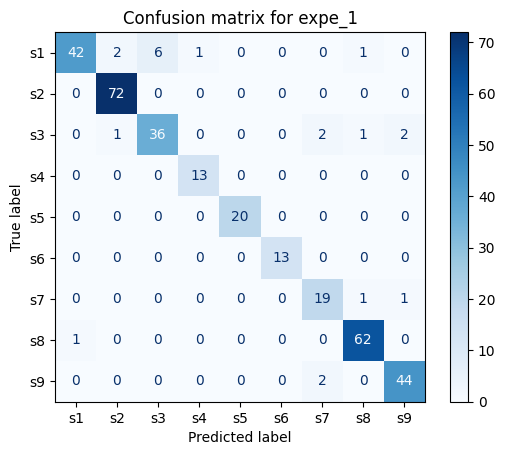

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


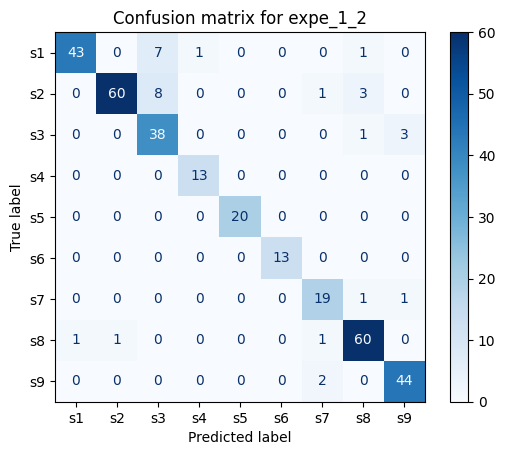

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


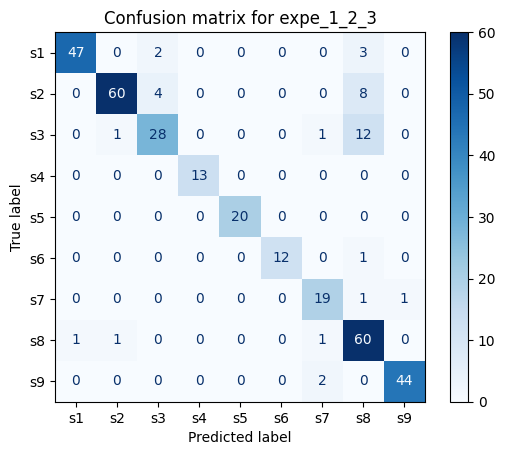

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


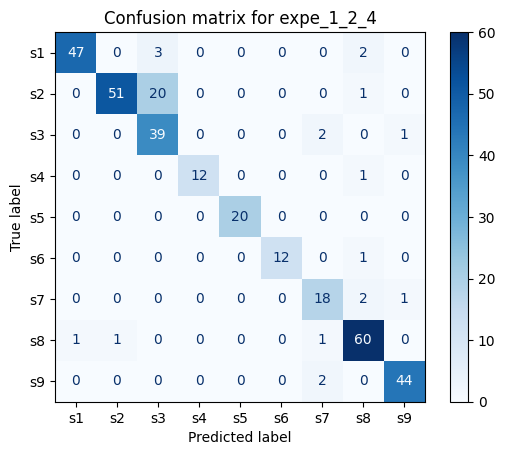

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


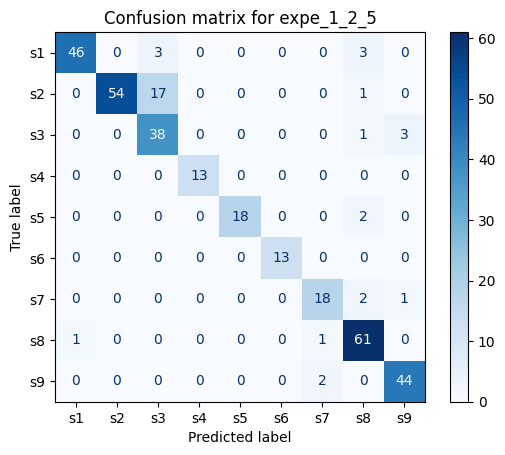

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


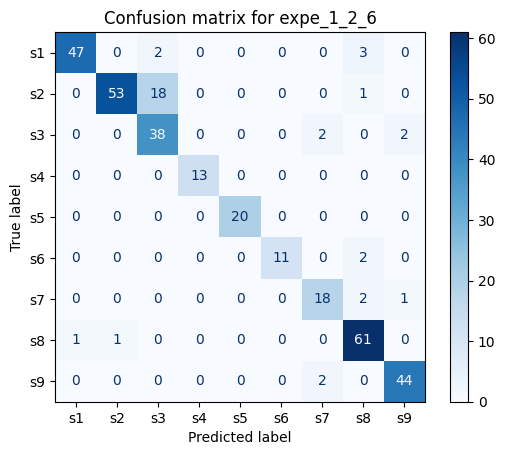

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


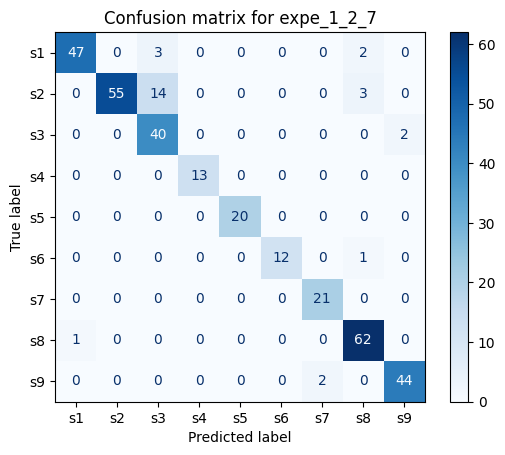

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


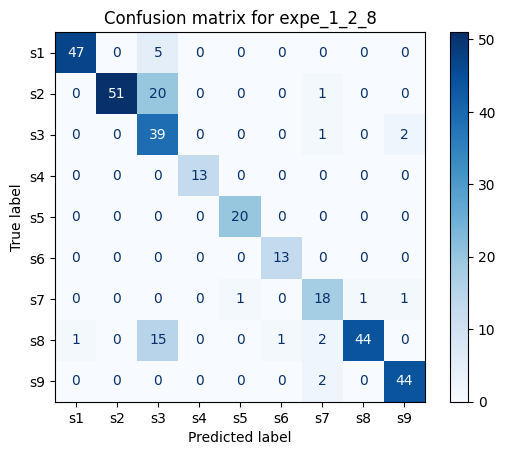

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


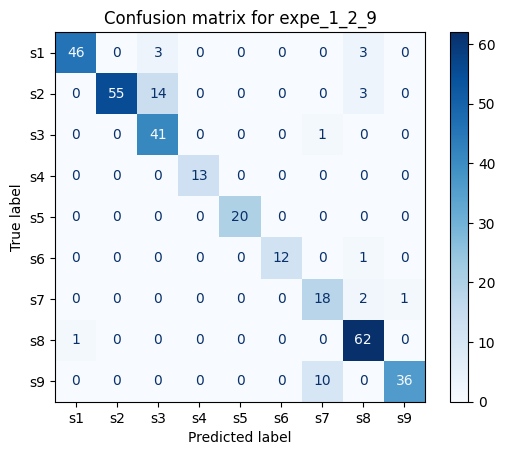

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


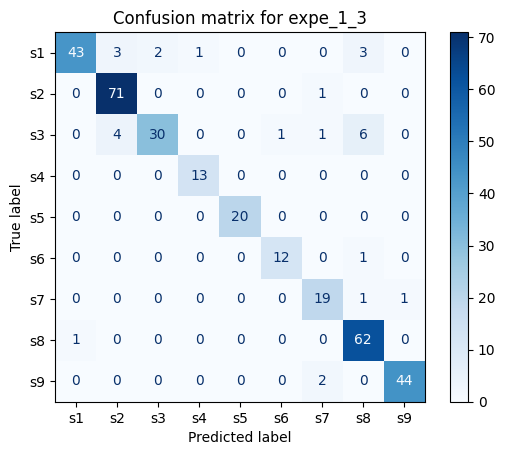

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


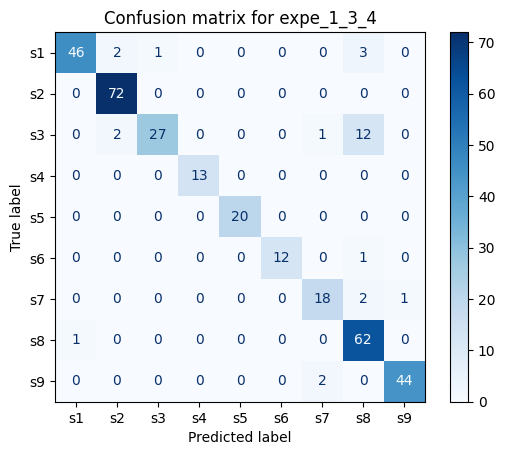

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


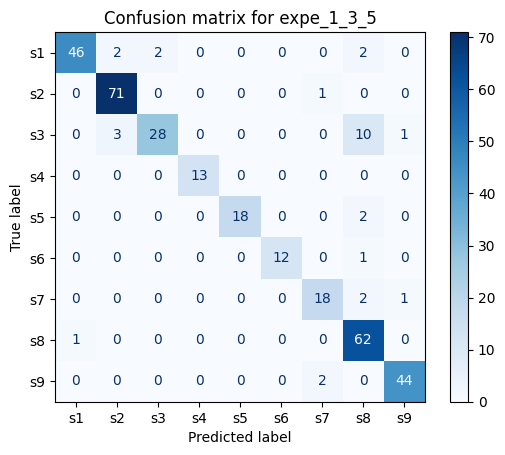

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


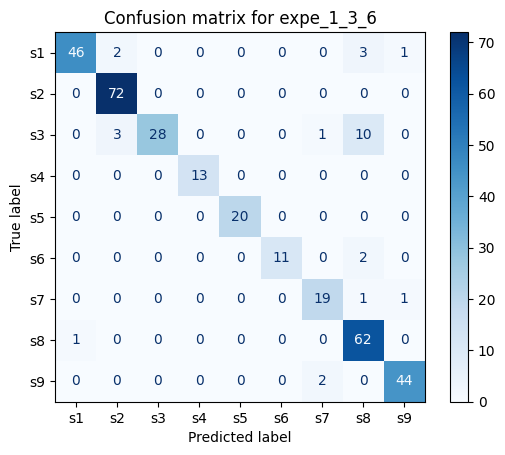

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


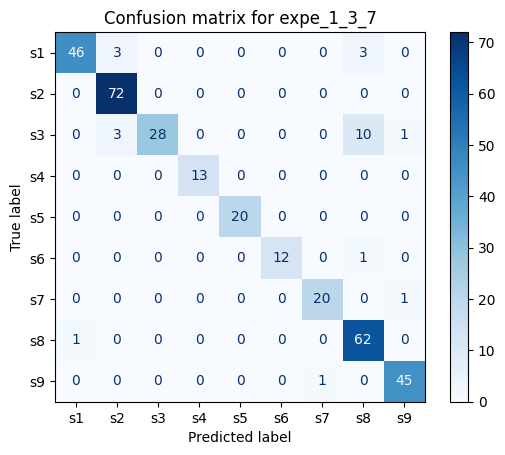

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


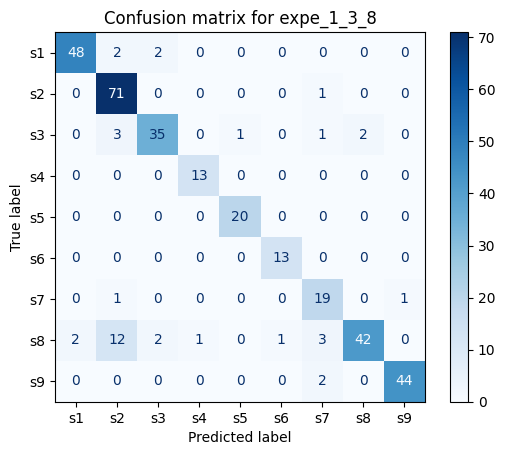

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


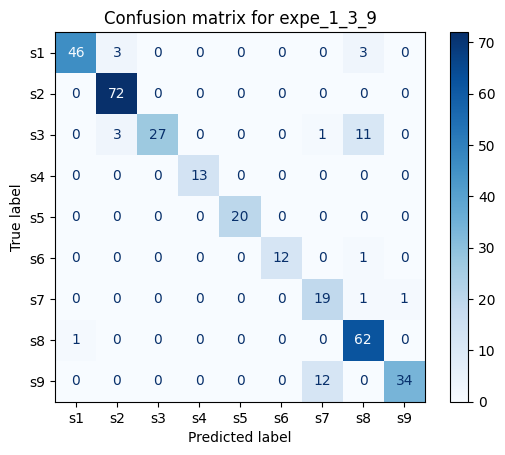

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


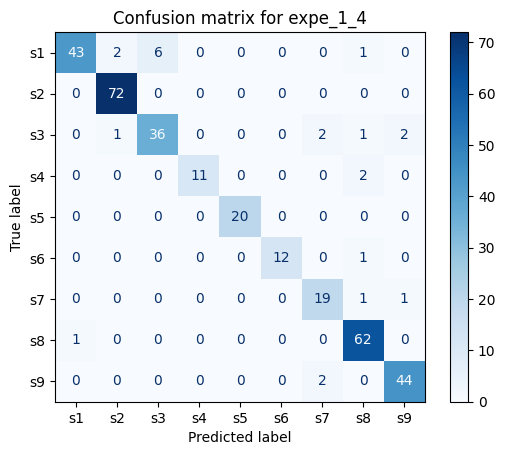

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


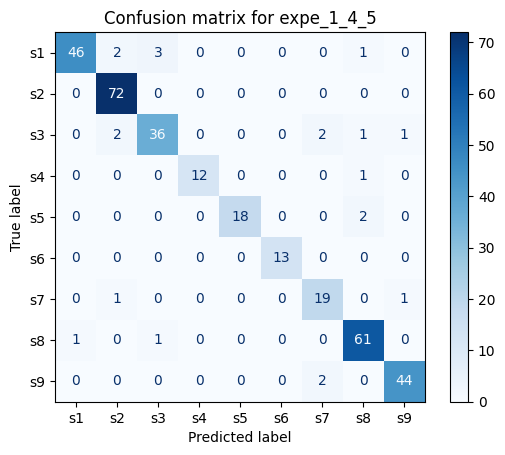

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


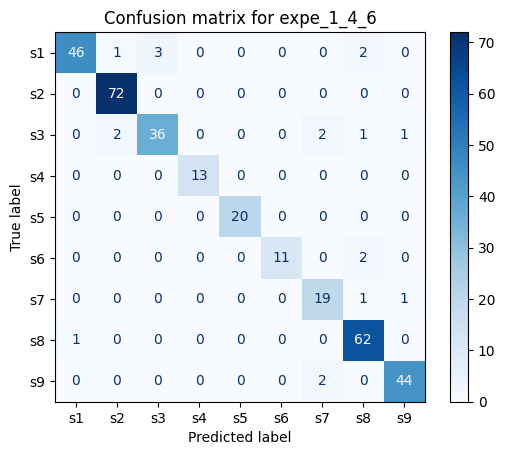

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


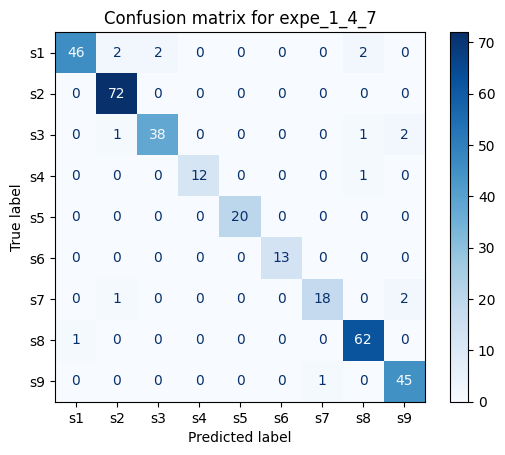

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


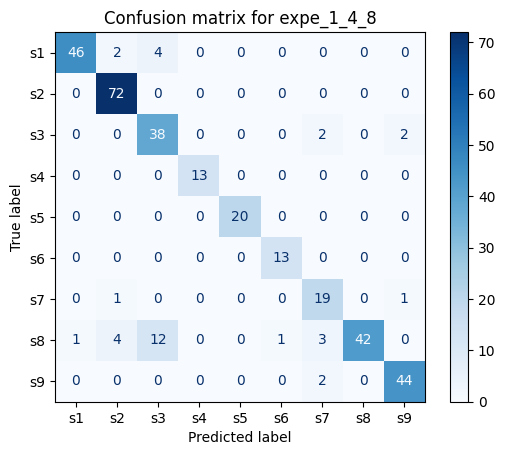

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


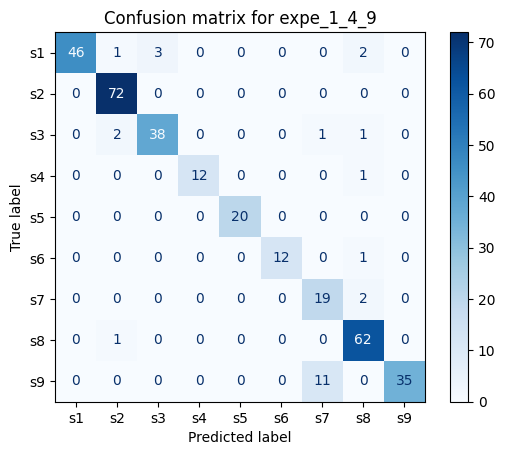

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


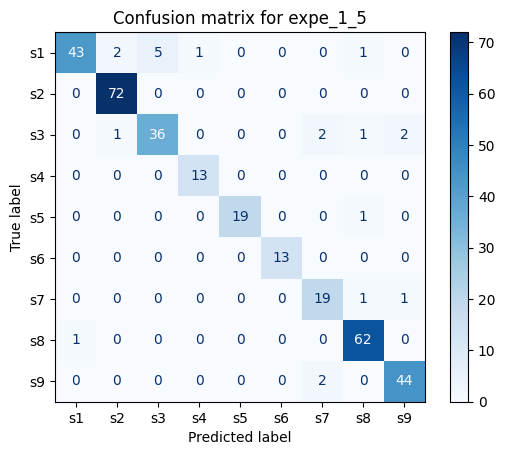

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


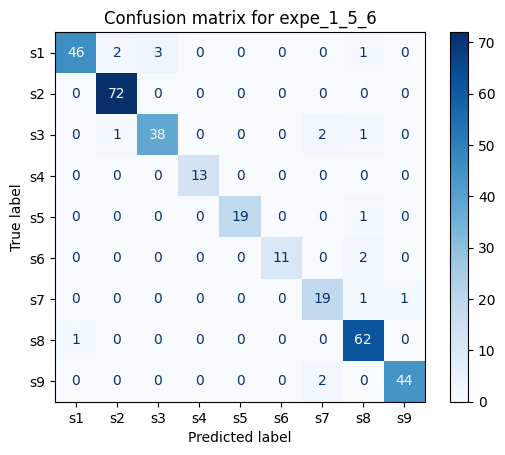

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


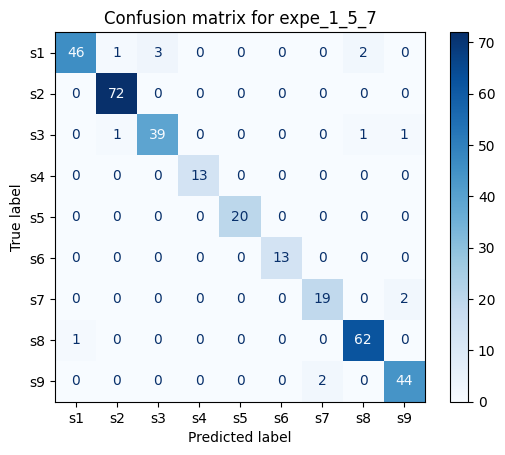

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


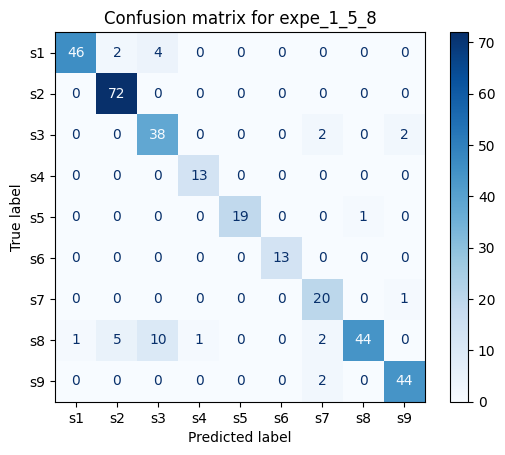

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


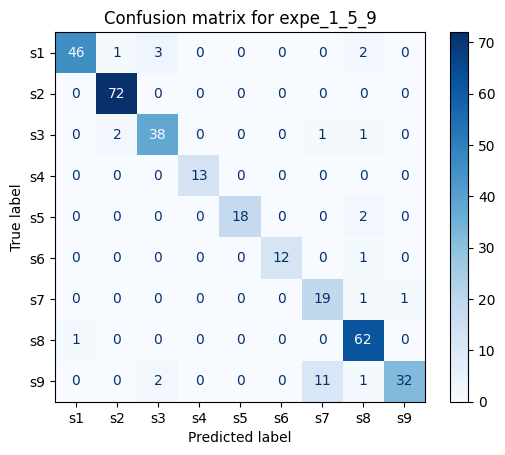

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


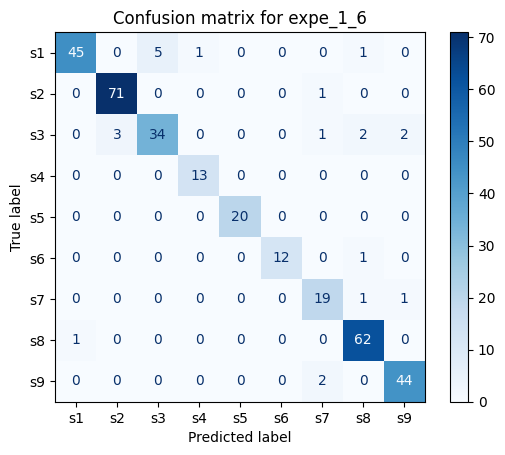

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


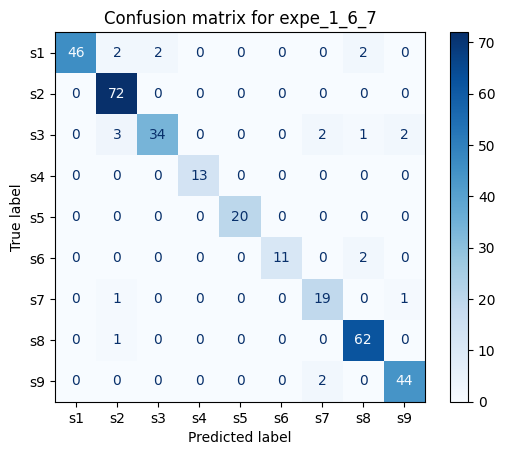

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


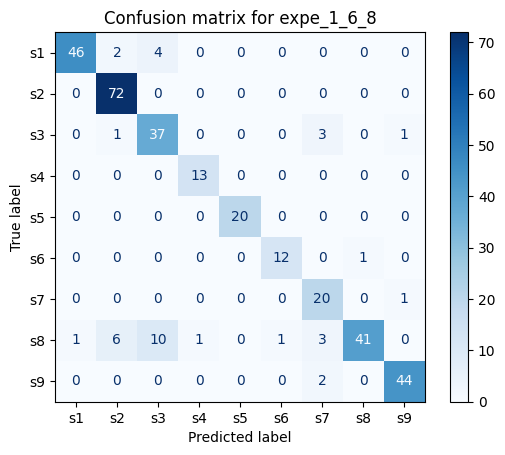

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


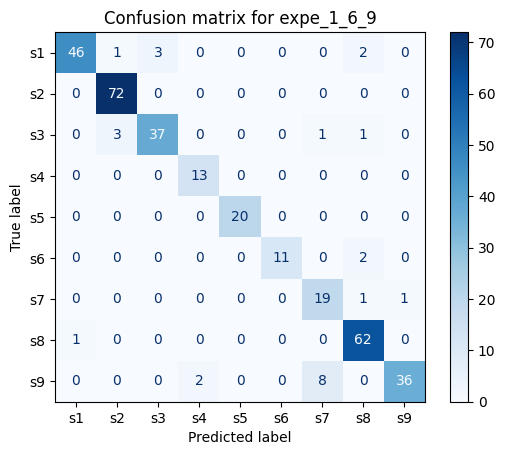

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


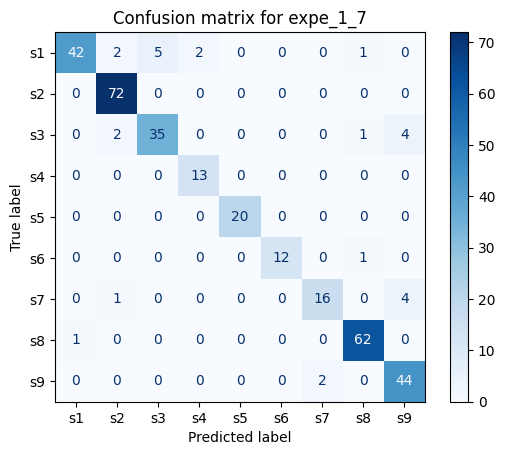

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


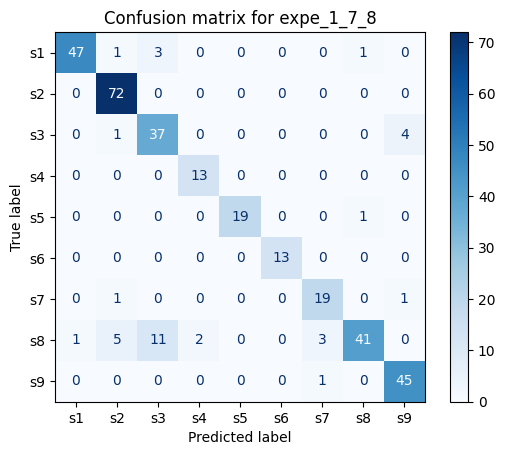

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


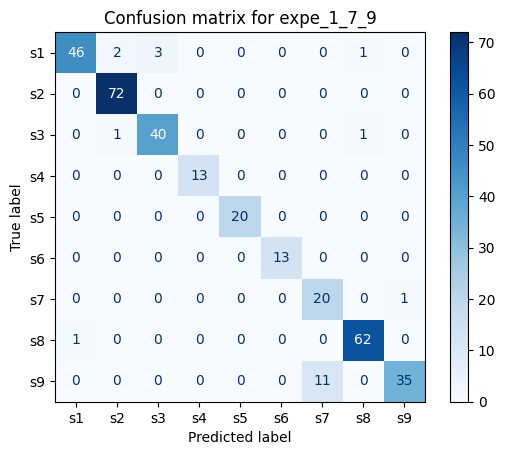

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


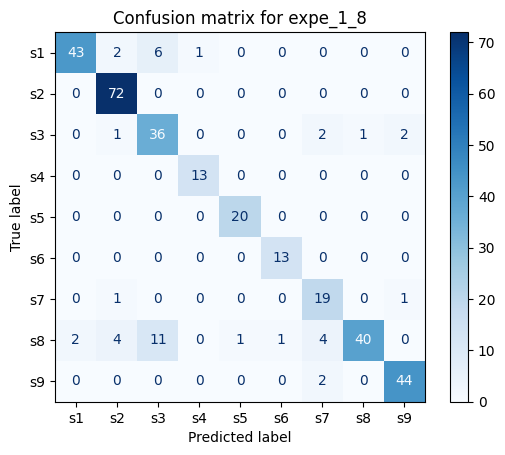

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


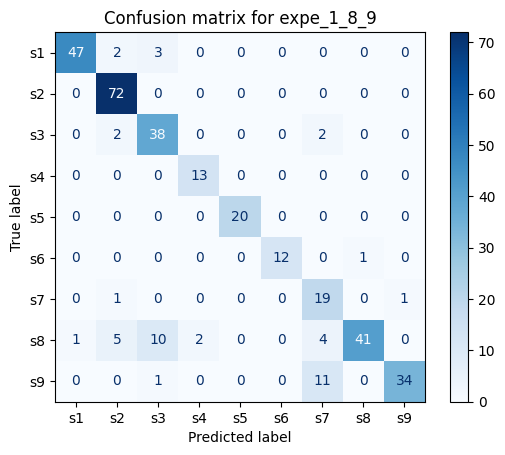

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


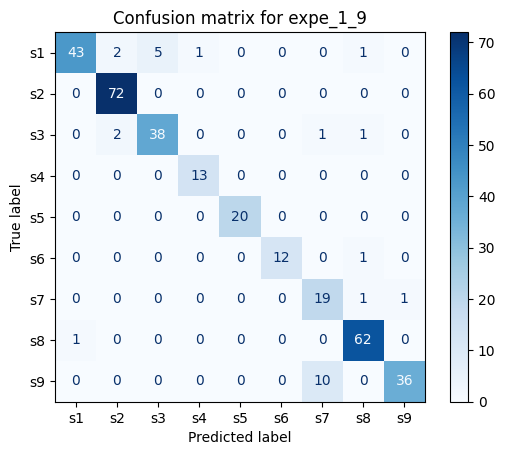

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


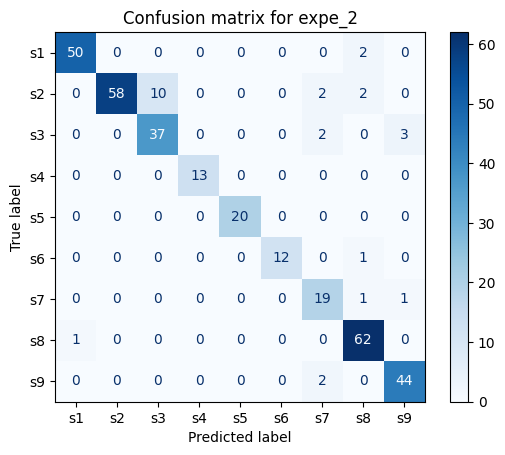

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


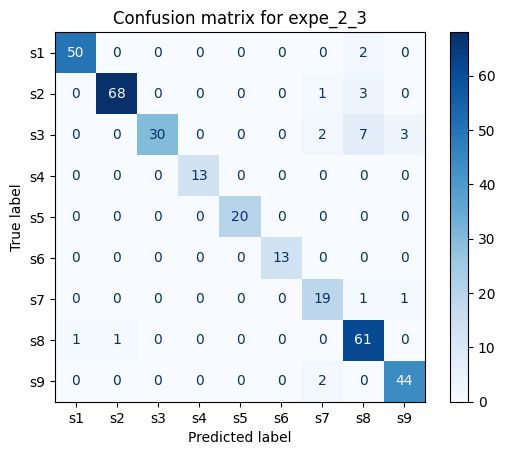

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


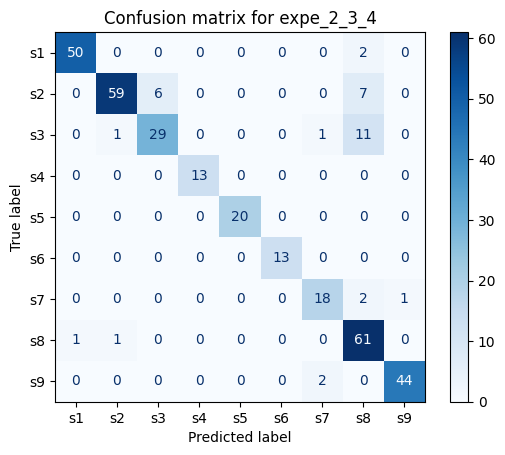

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


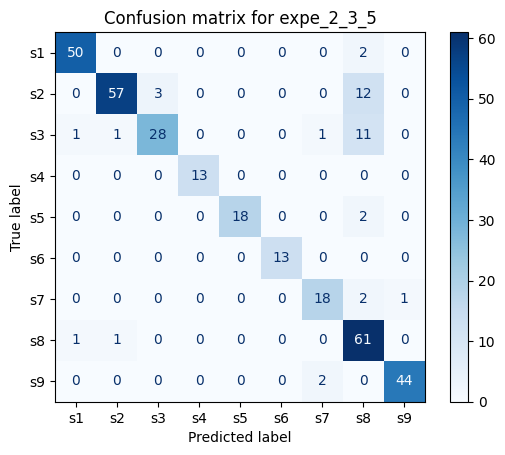

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


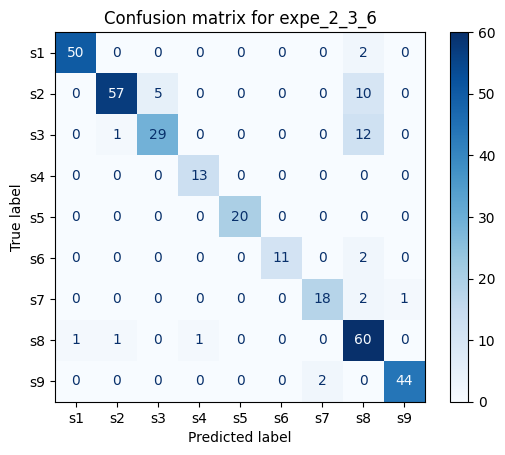

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


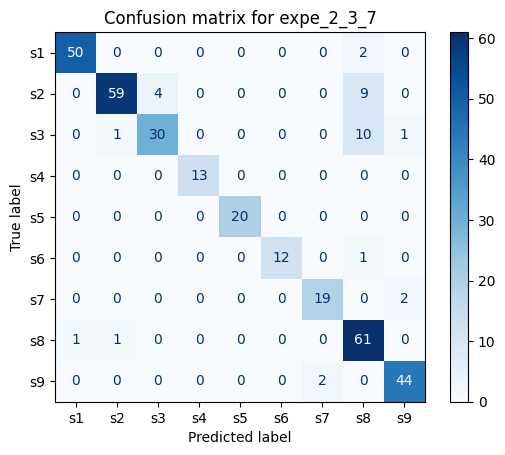

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


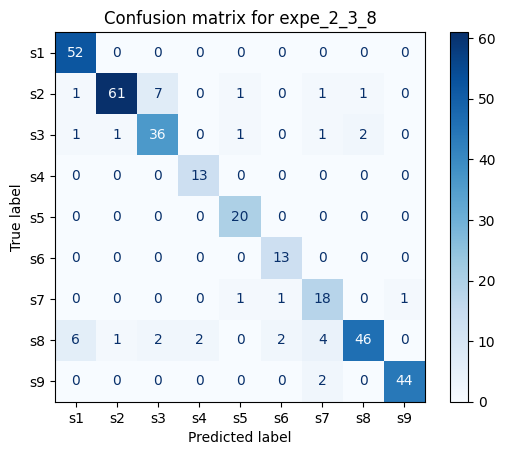

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


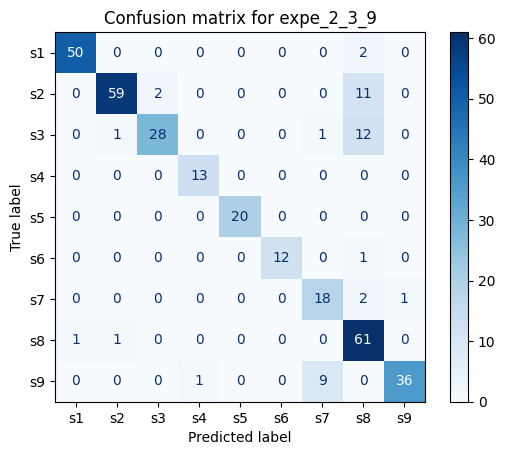

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


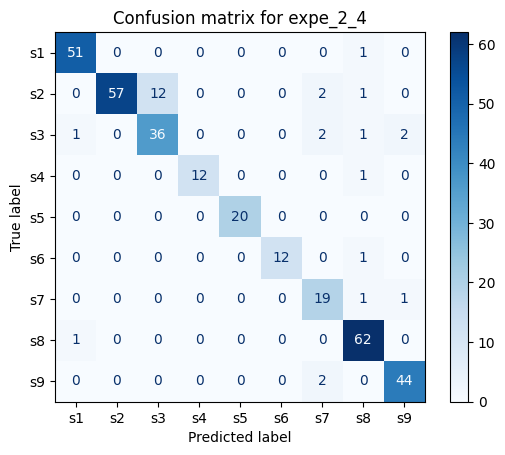

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


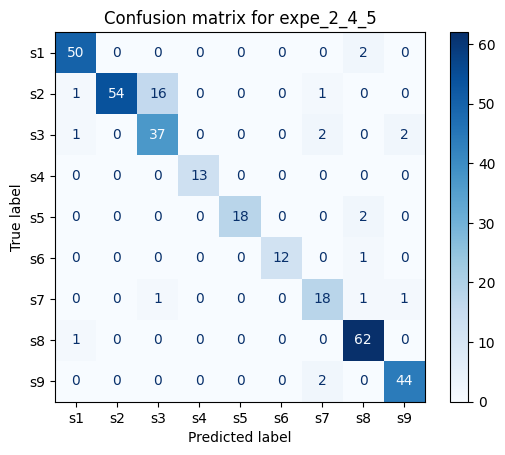

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


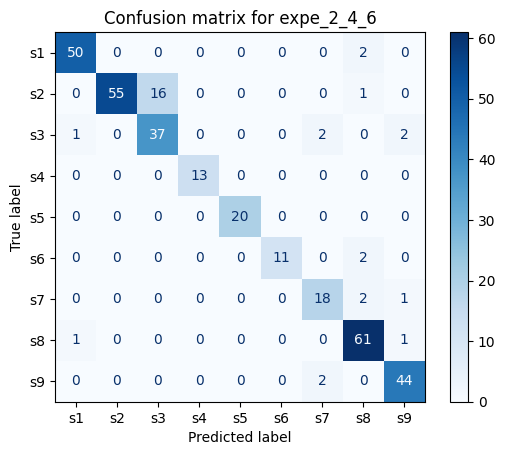

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


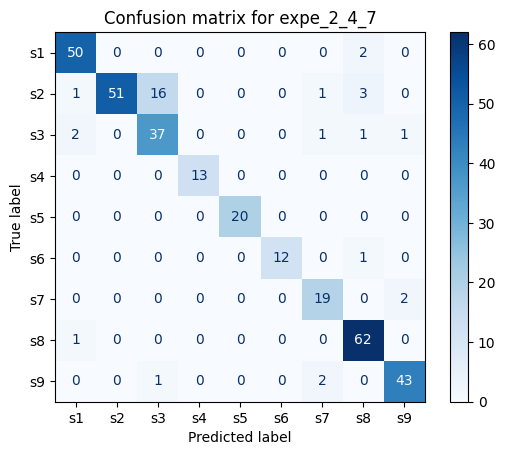

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


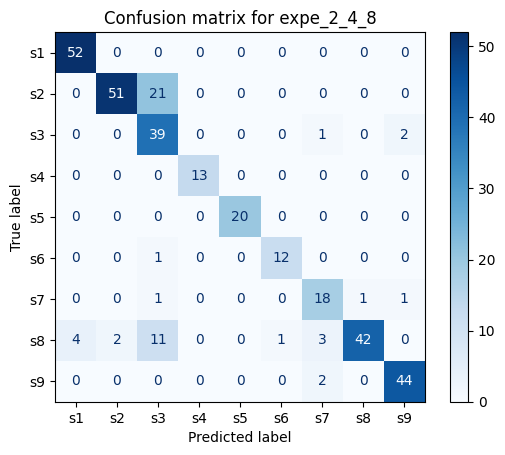

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


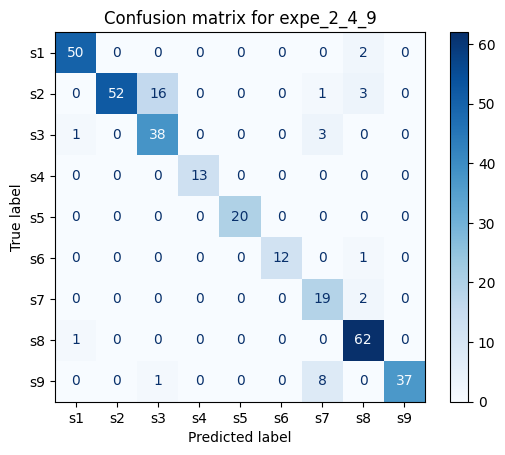

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


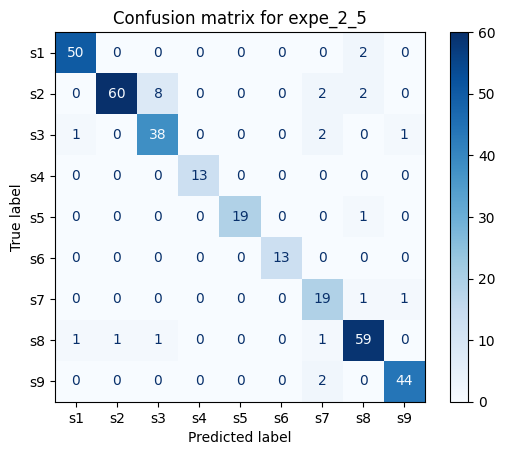

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


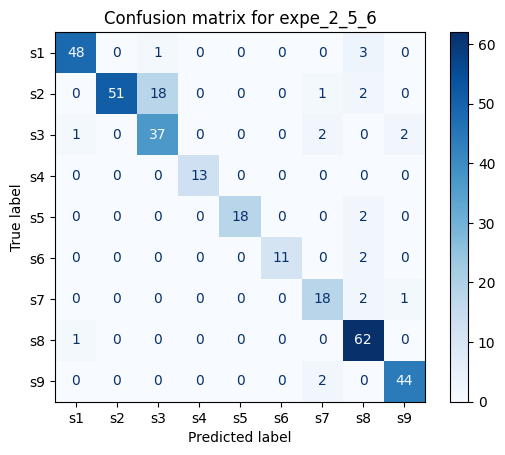

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


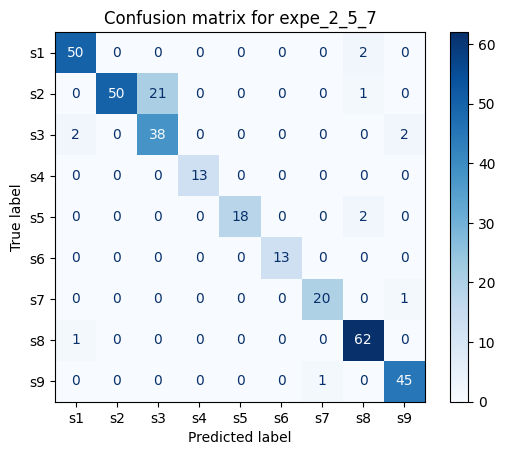

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


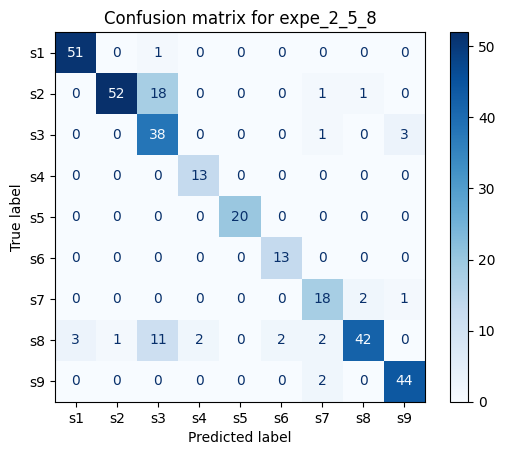

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


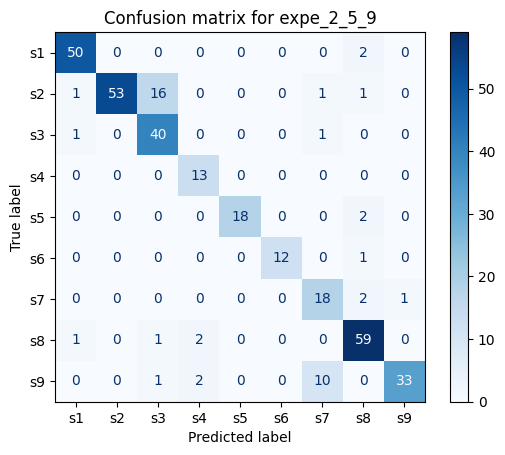

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


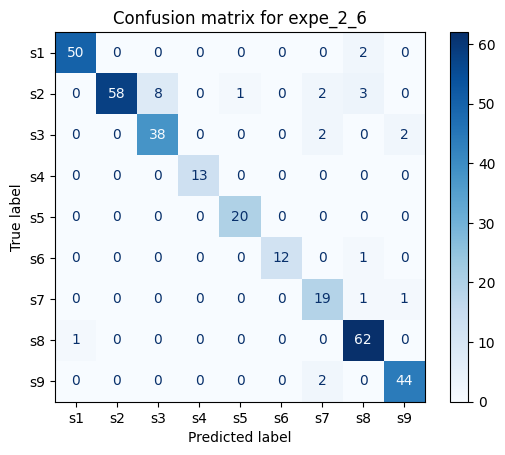

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


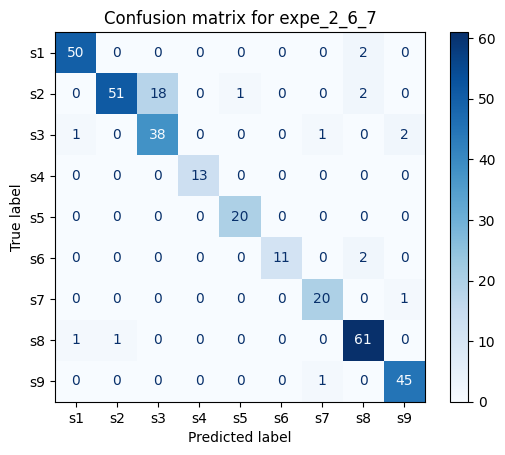

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


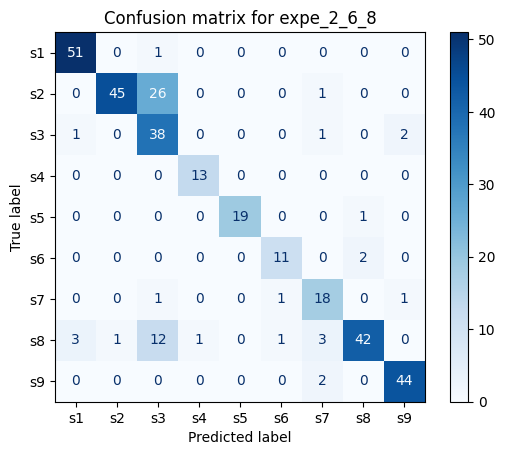

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


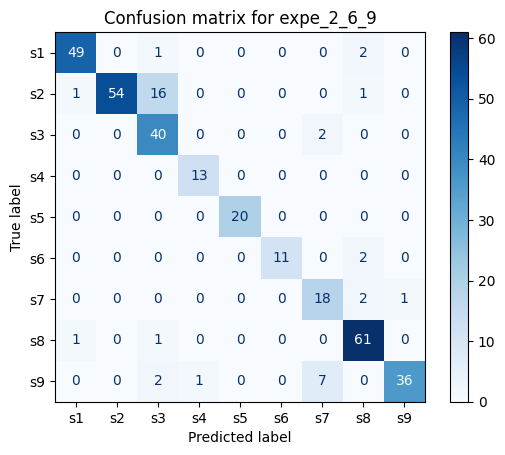

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


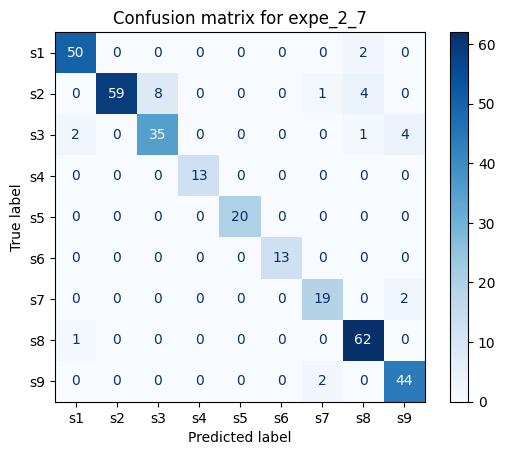

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


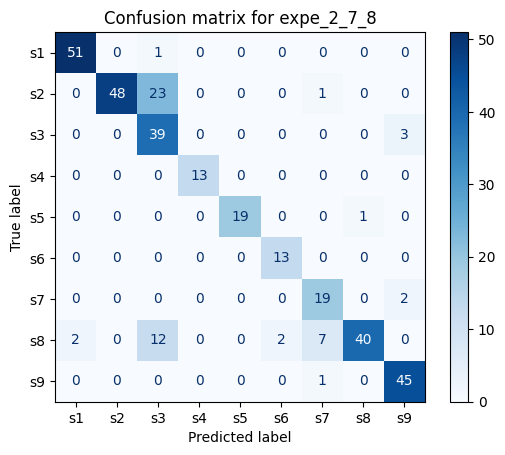

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


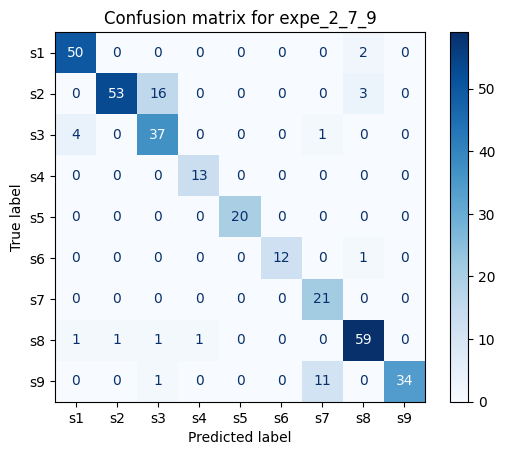

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


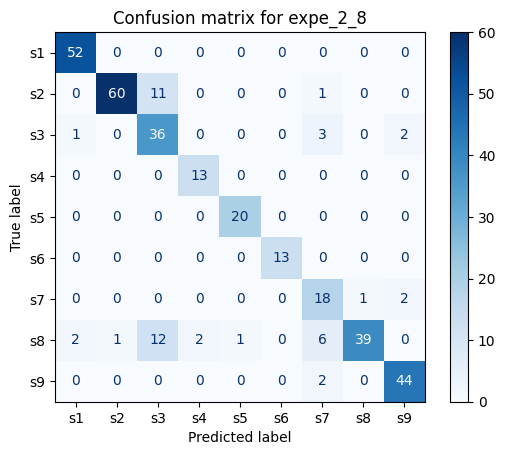

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


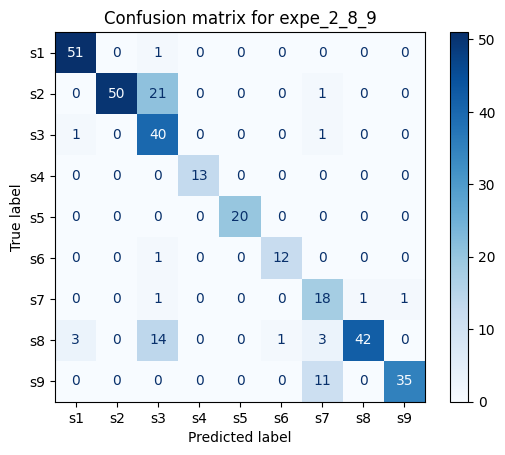

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


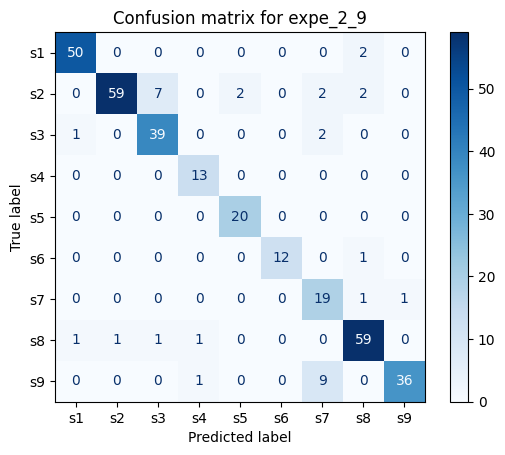

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


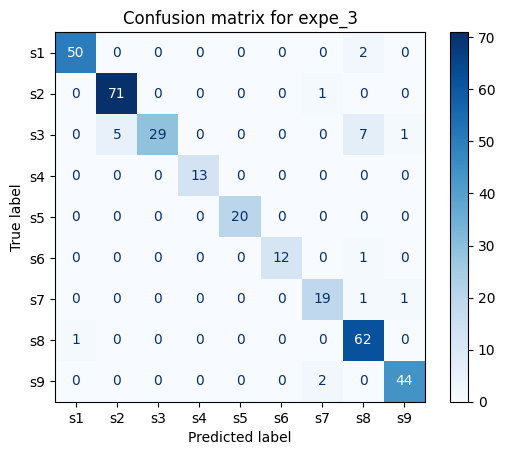

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


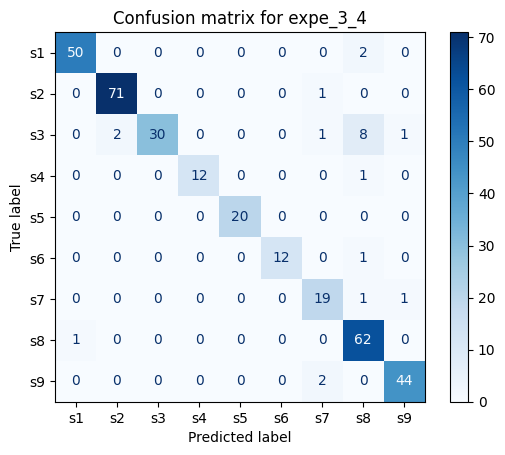

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


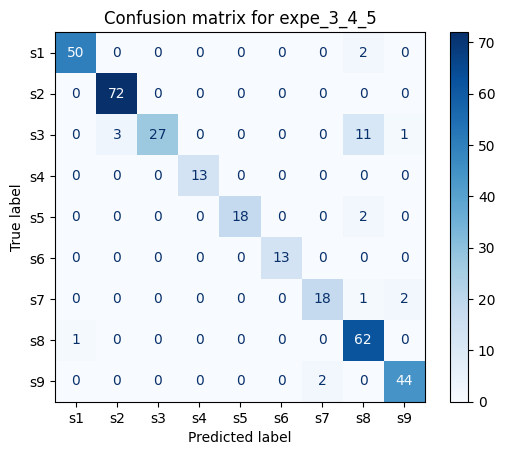

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


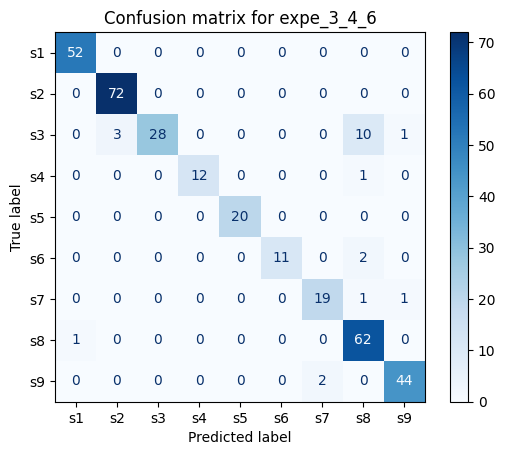

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


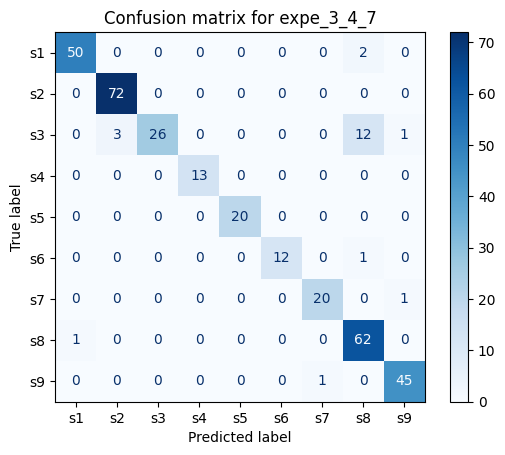

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


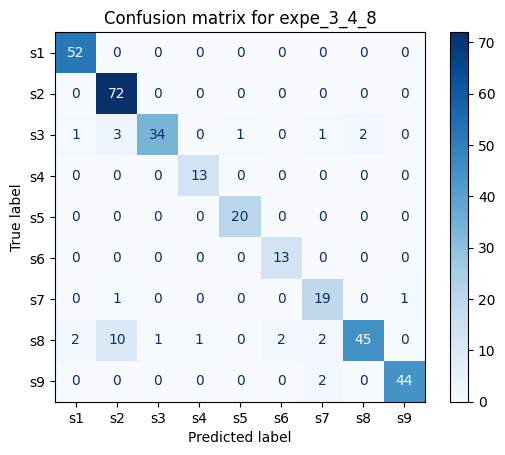

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


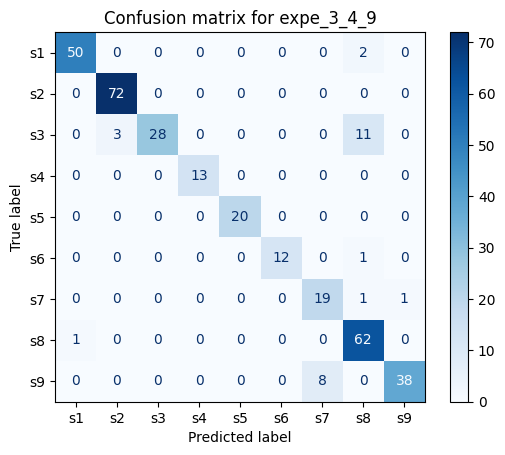

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


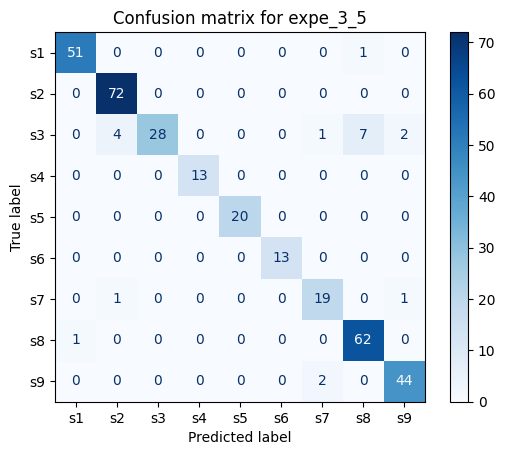

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


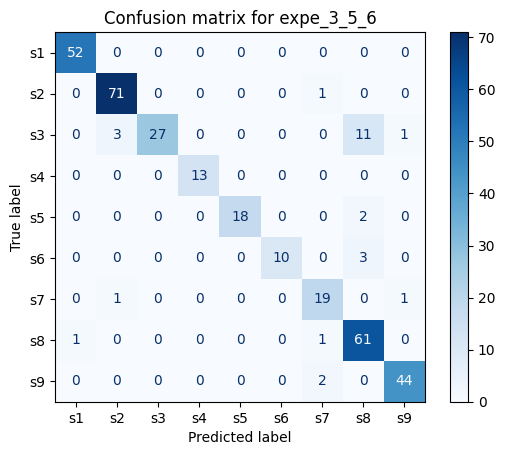

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


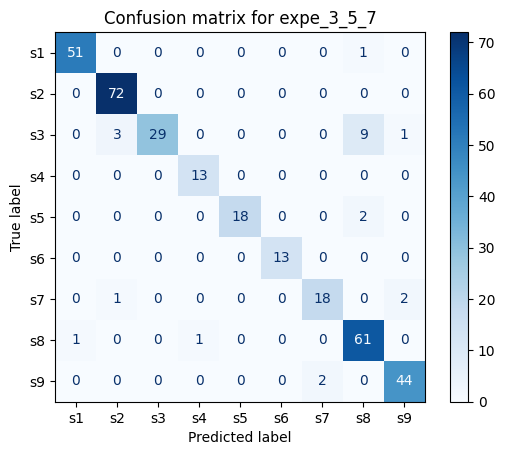

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


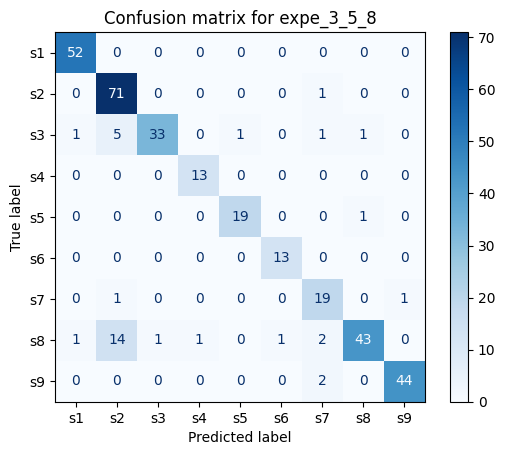

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


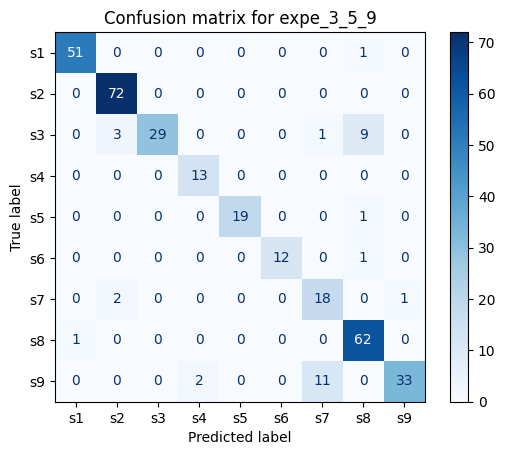

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


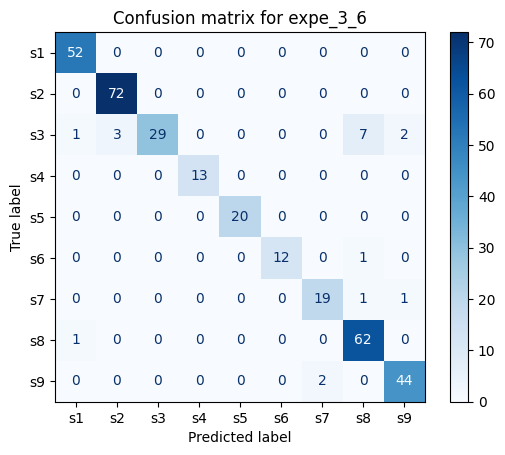

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


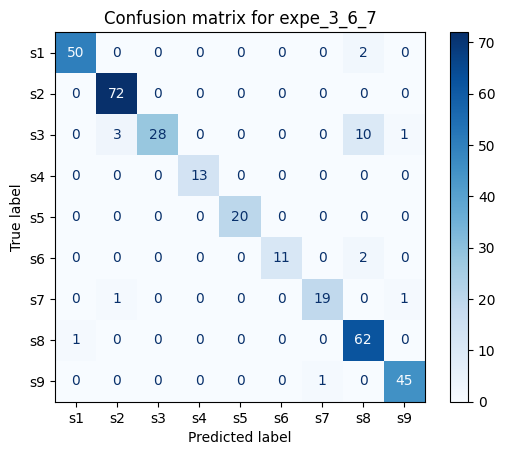

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


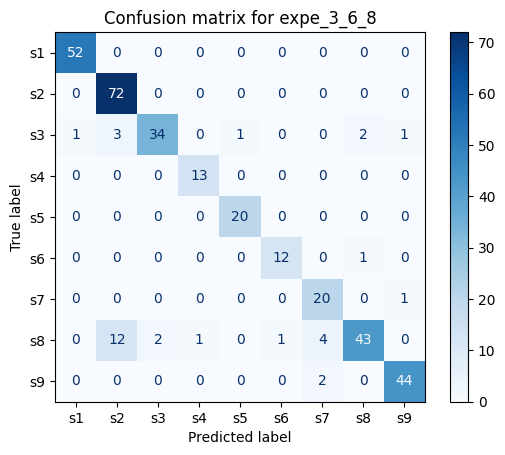

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


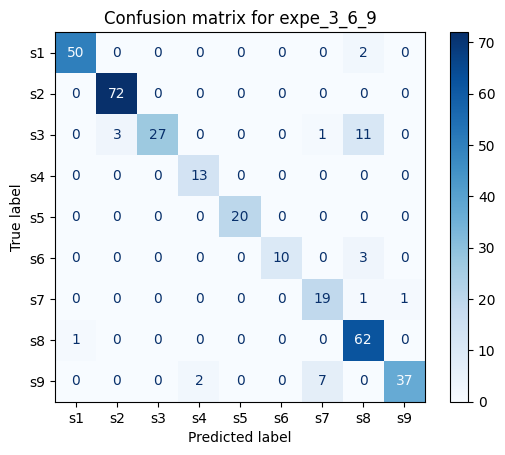

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


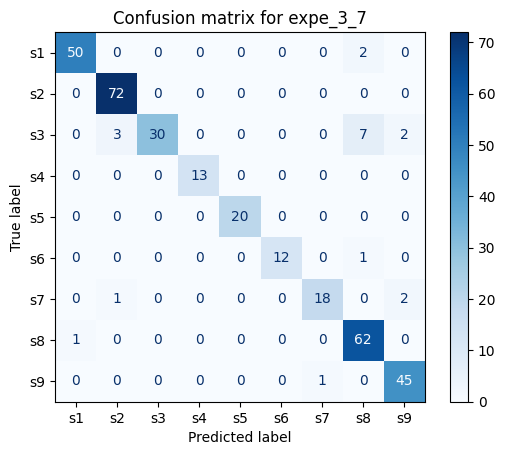

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


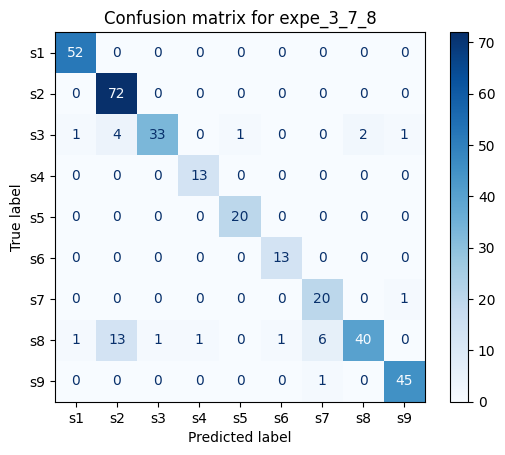

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


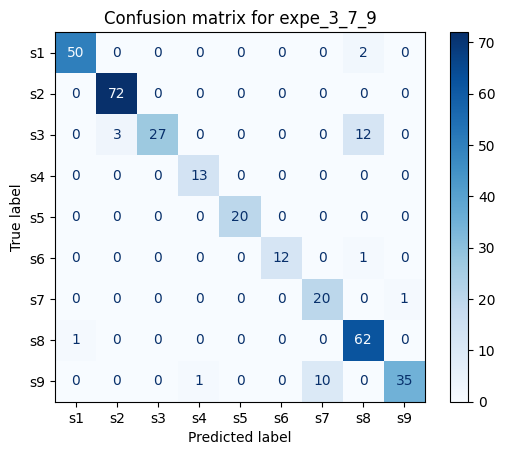

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


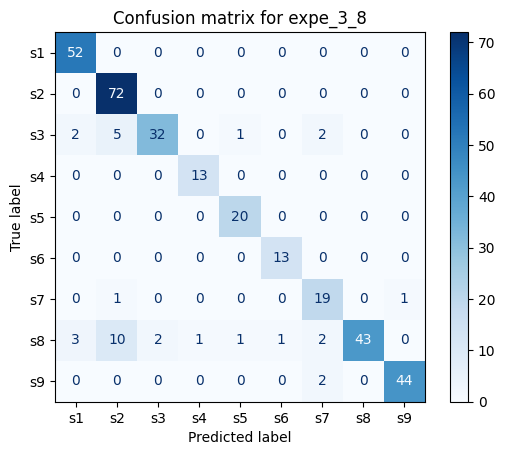

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


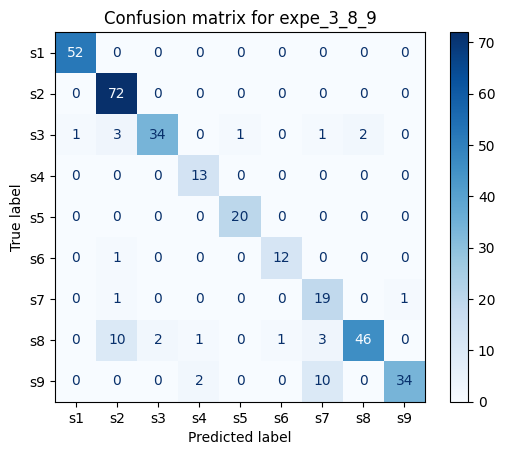

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


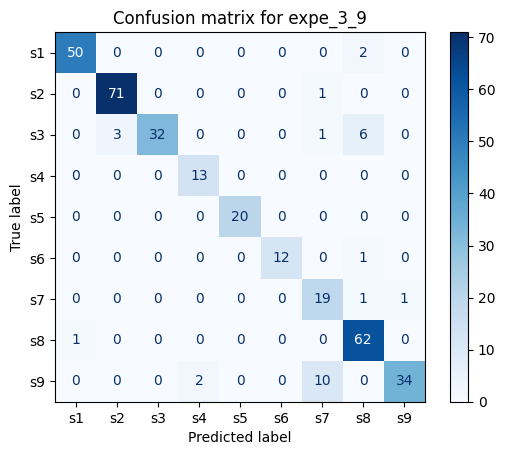

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


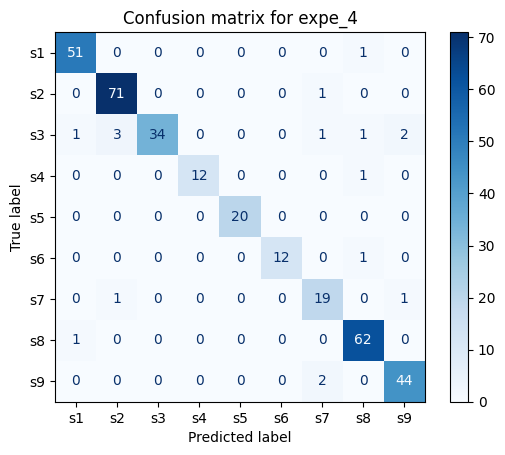

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


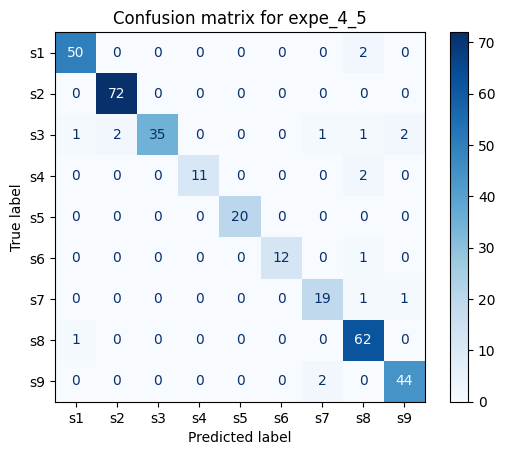

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


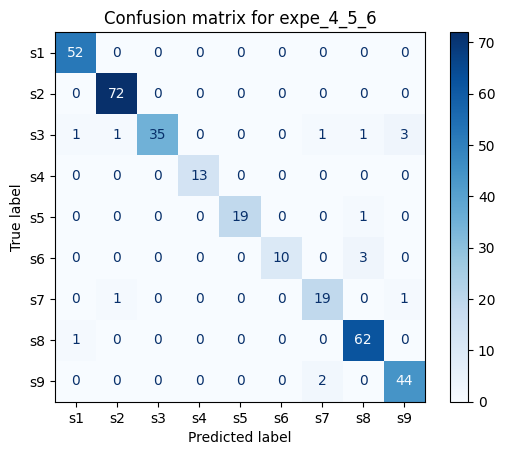

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


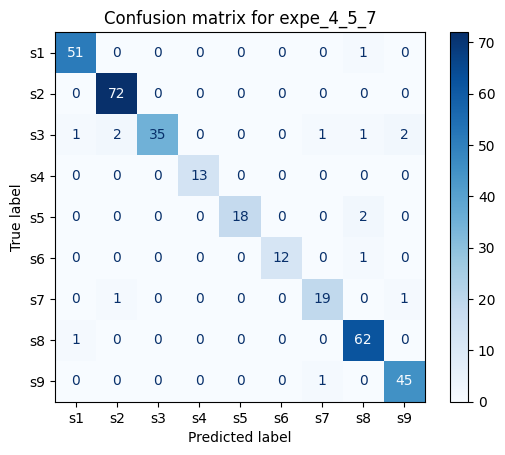

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


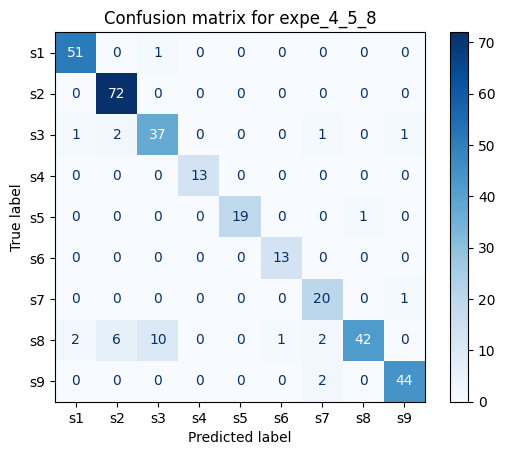

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


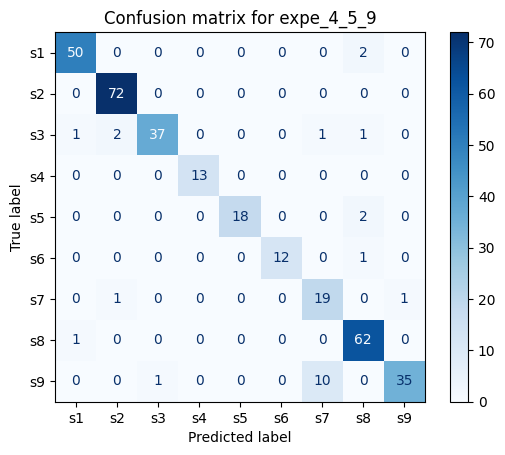

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


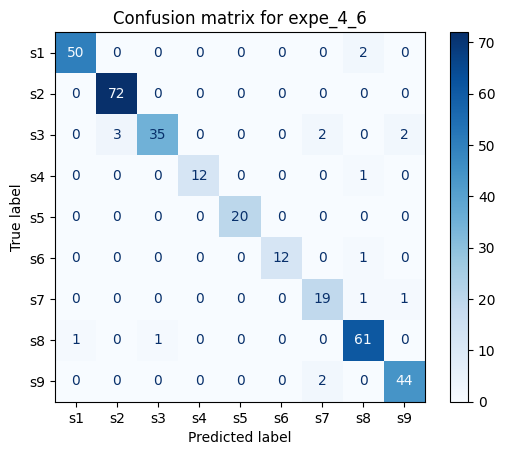

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


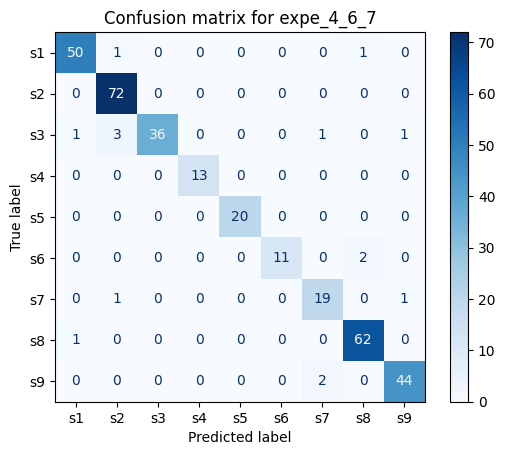

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


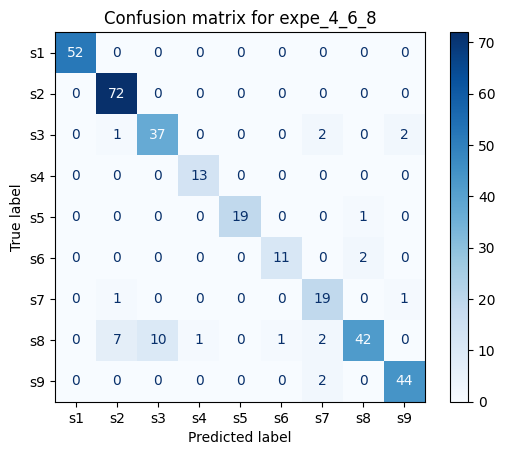

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


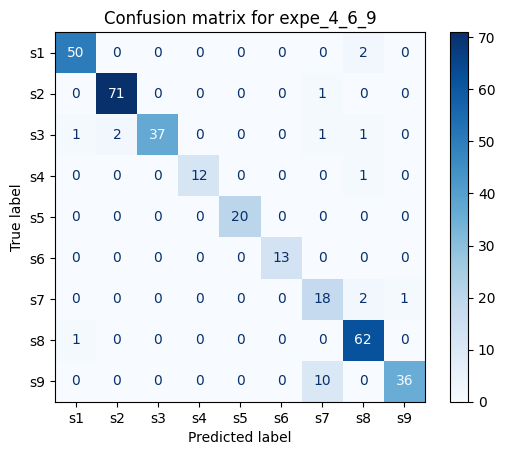

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


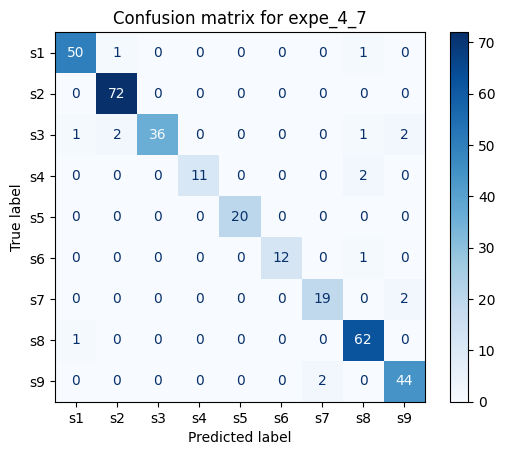

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


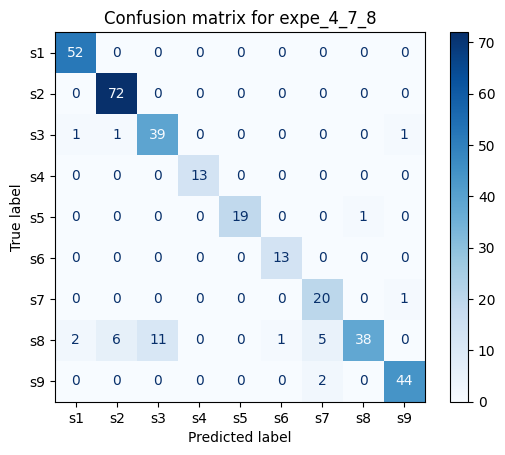

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


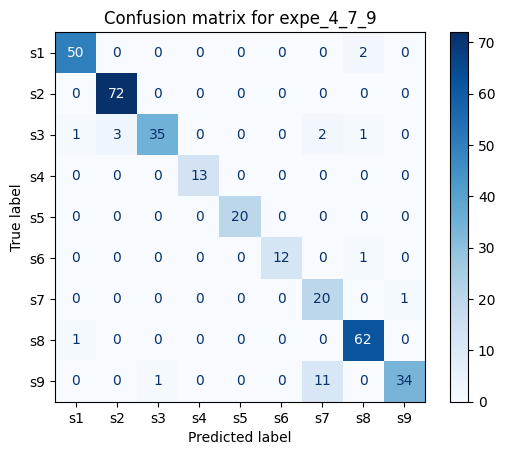

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


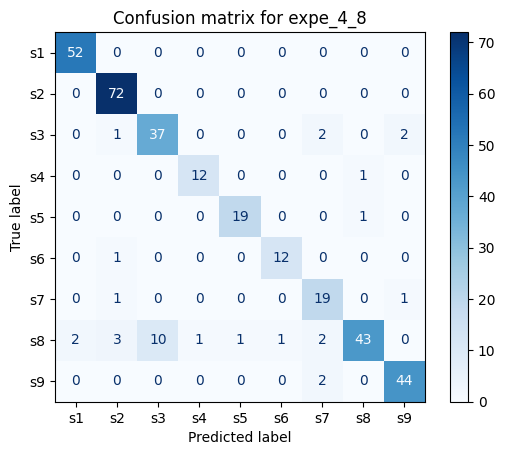

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


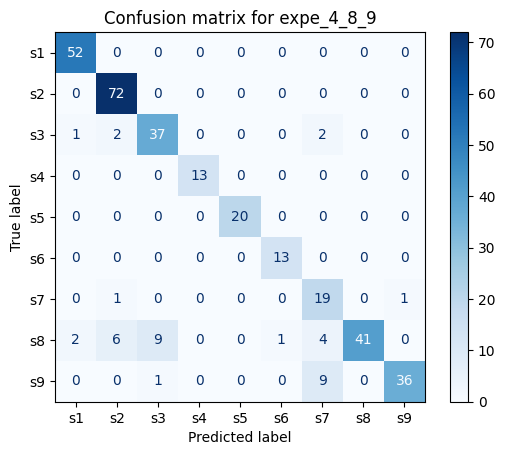

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


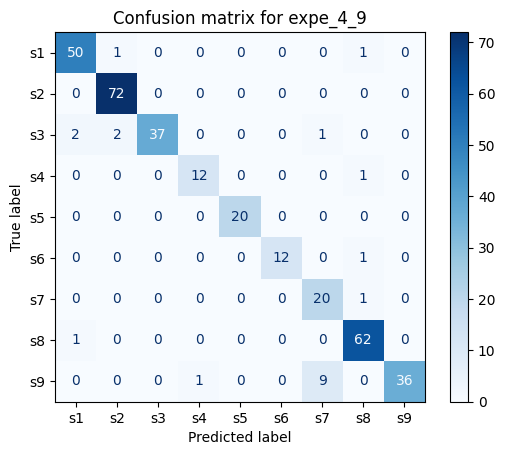

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


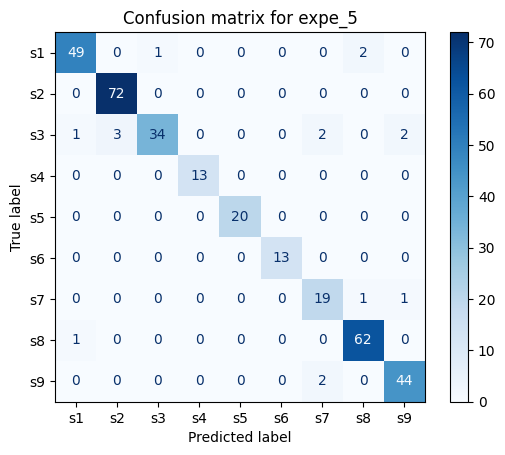

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


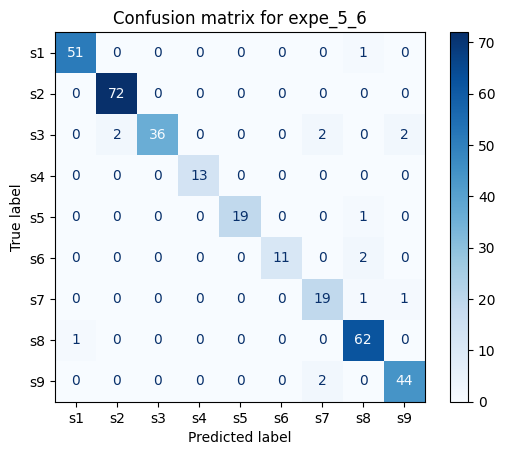

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


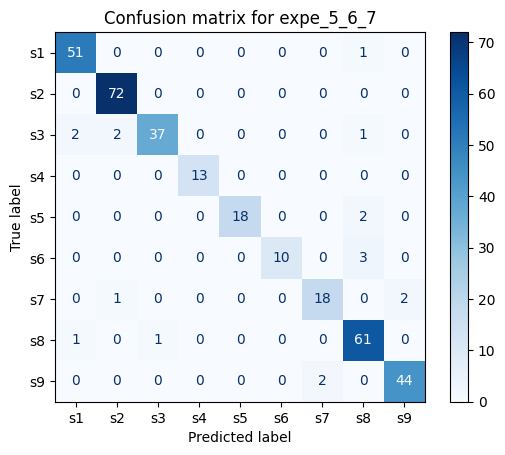

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


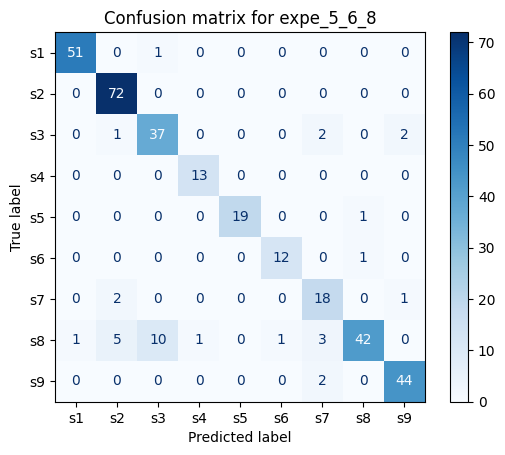

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


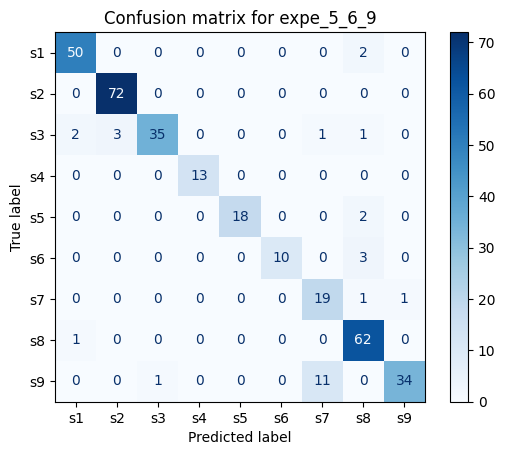

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


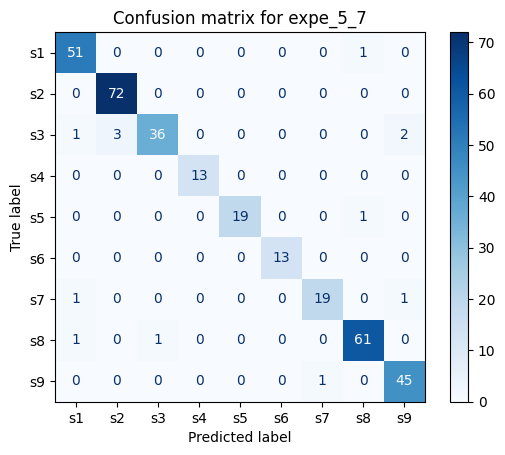

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


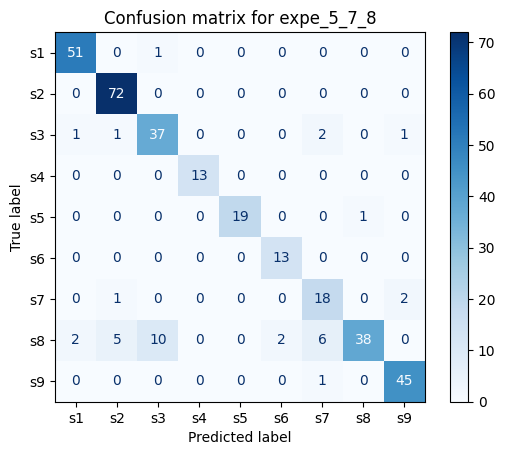

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


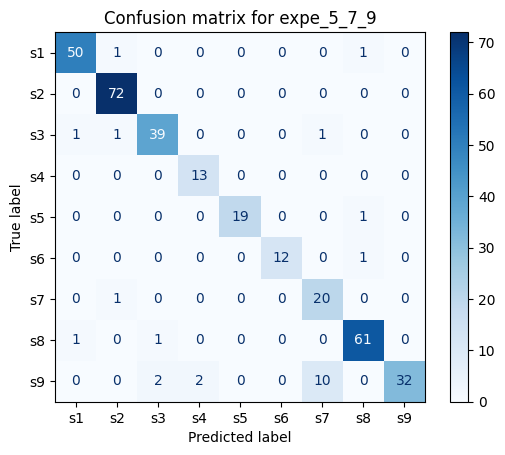

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


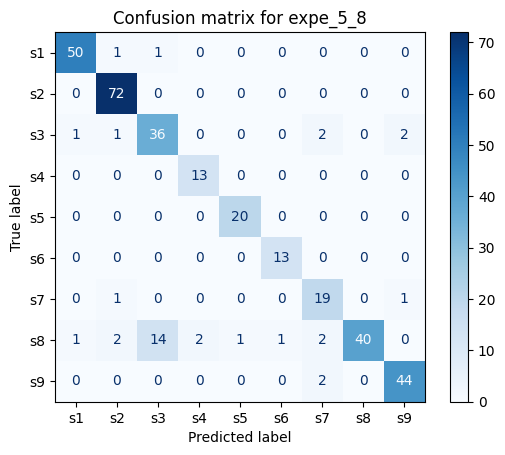

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


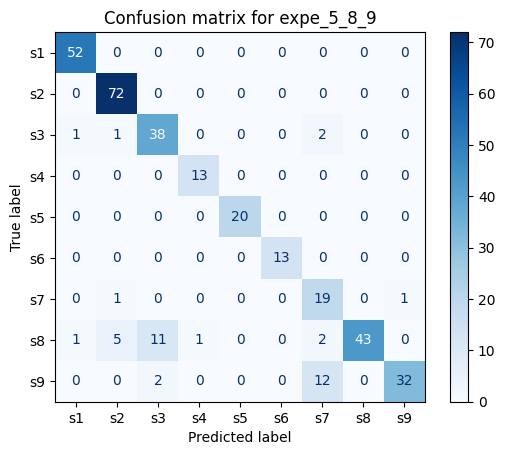

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


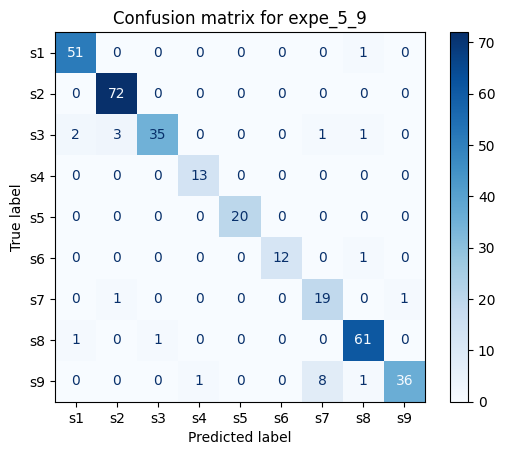

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


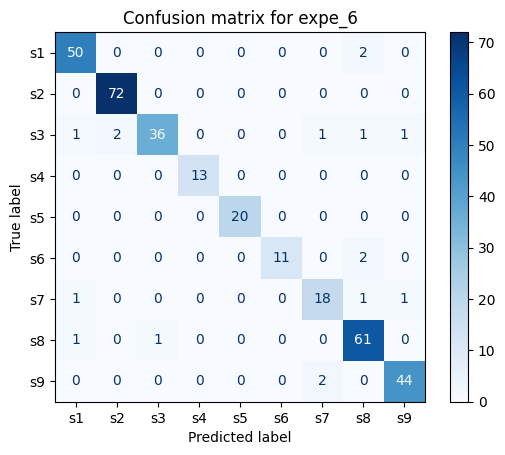

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


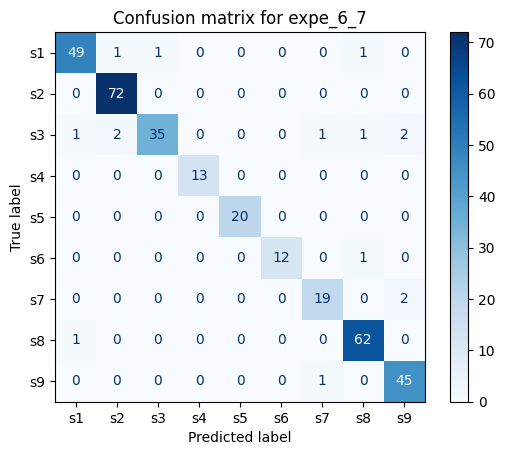

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


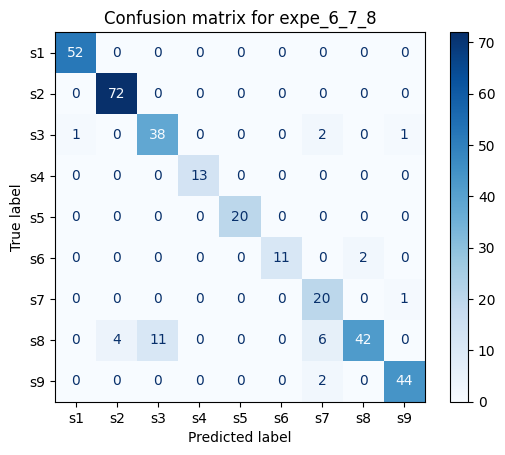

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


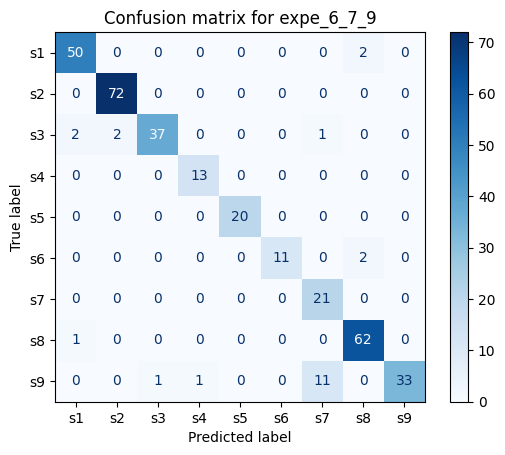

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


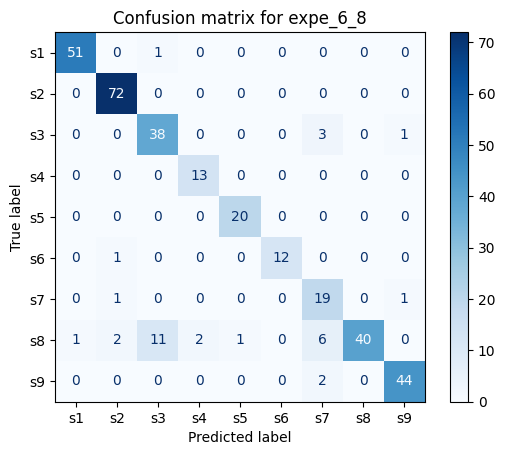

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


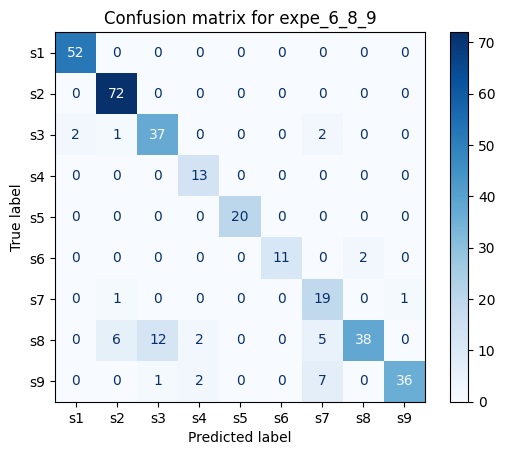

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


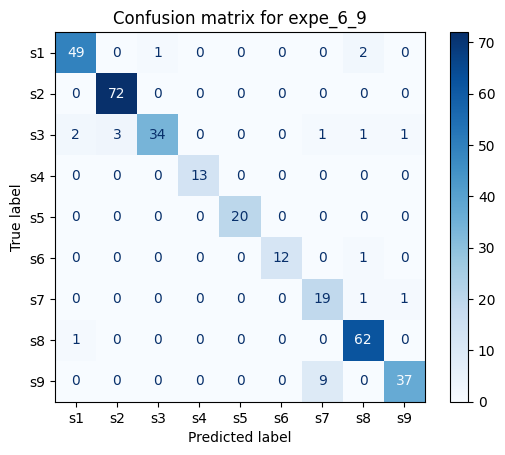

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


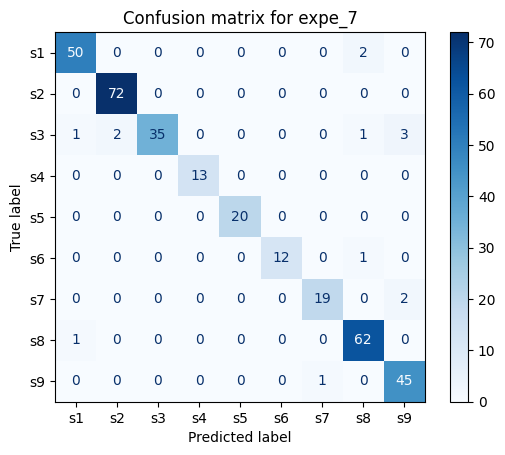

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


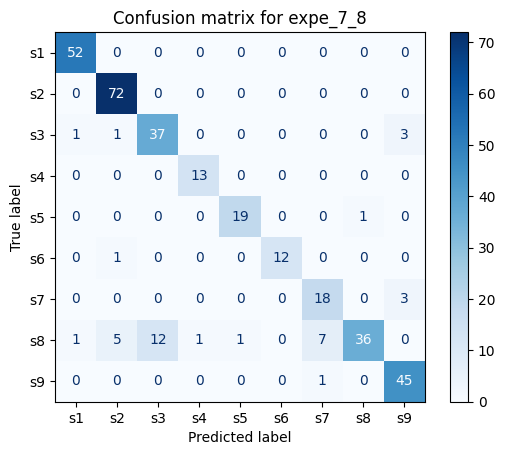

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


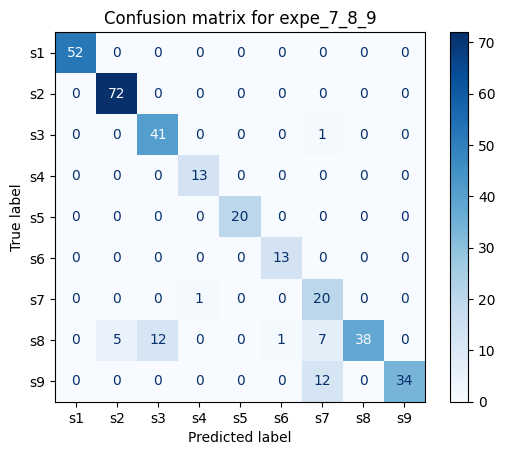

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


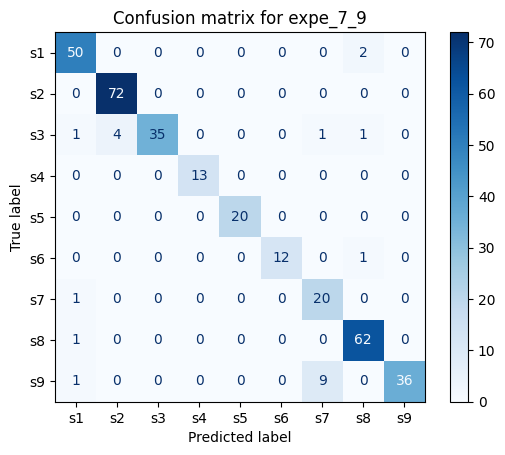

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


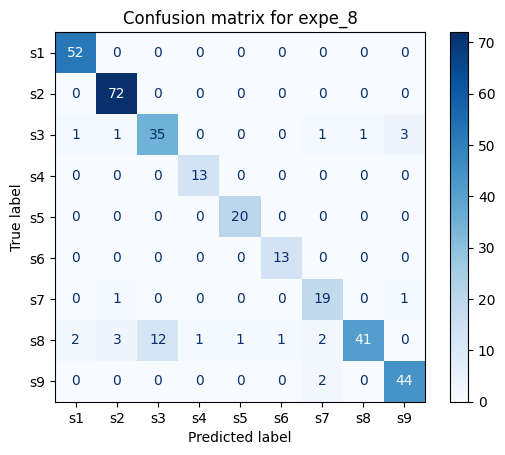

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


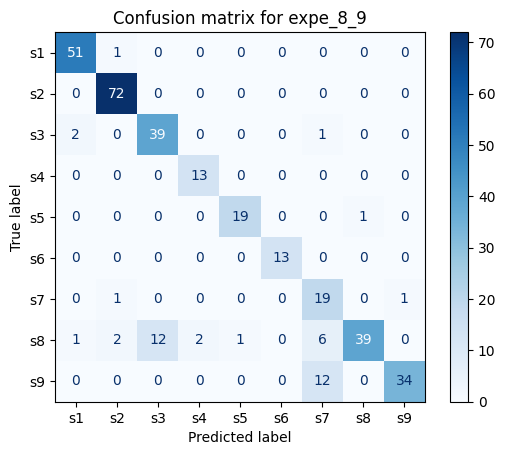

Modelo guardado en audio_classifier.pkl
Modelo cargado correctamente.


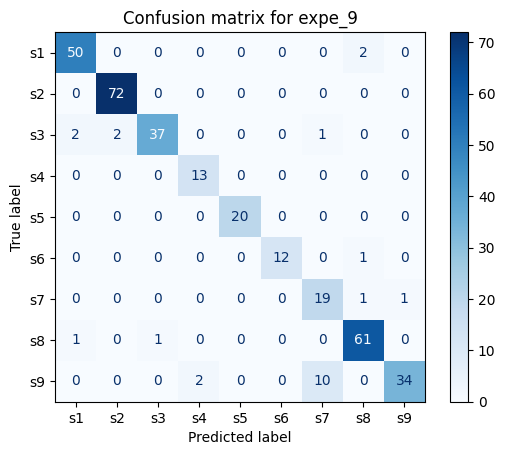

[['expe_1', 0.9402812339924947, 0.9385964912280702, 0.937785302598337], ['expe_1_2', 0.9212323411039886, 0.9064327485380117, 0.9078043931382391], ['expe_1_2_3', 0.9082049594225556, 0.8859649122807017, 0.8873857940418489], ['expe_1_2_4', 0.9033734583944963, 0.8859649122807017, 0.8886007917756644], ['expe_1_2_5', 0.9116011678311042, 0.8918128654970761, 0.8940297951170036], ['expe_1_2_6', 0.9072916437382553, 0.8918128654970761, 0.8936363889901616], ['expe_1_2_7', 0.9368727355040384, 0.9181286549707602, 0.919124681273443], ['expe_1_2_8', 0.8792800538746226, 0.8450292397660819, 0.8548322395692782], ['expe_1_2_9', 0.898697519491425, 0.8859649122807017, 0.8886770730063149], ['expe_1_3', 0.9201983037113757, 0.9181286549707602, 0.9163069078841354], ['expe_1_3_4', 0.9250003516670184, 0.9181286549707602, 0.9162870569888115], ['expe_1_3_5', 0.9178669578306453, 0.9122807017543859, 0.9108550672487571], ['expe_1_3_6', 0.9257864269395777, 0.9210526315789473, 0.9192578551502376], ['expe_1_3_7', 0.94016

In [35]:
import os
import librosa
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def extract_features(file_path,sample_rate,duration,n_mfcc):
    """
    Extracts audio features (mean MFCCs) from a given audio file.

    Parameters:
    -----------
    file_path : str
        Path to the audio file (e.g., .wav).
    sample_rate : int
        Target sampling rate (in Hz) for loading the audio.
    duration : float
        Duration (in seconds) of the audio to load from the start.
    n_mfcc : int
        Number of MFCC (Mel-Frequency Cepstral Coefficients) to extract.

    Returns:
    --------
    np.ndarray
        A 1D array containing the mean MFCC values across all frames.

    Notes:
    ------
    - If the loaded audio is shorter than `sample_rate` samples, it is zero-padded.
    - MFCCs are computed and then averaged across the time axis (frames).
    """
    y, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
    if len(y) < SAMPLE_RATE:
        y = np.pad(y, (0, sample_rate - len(y)))
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

def load_data(data_dir,sample_rate,duration,n_mfcc):
    X, y = [], []
    labels = sorted(os.listdir(data_dir))
    for label in labels:
        class_dir = os.path.join(data_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            file_path = os.path.join(class_dir, fname)
            try:
                features = extract_features(file_path,sample_rate,duration,n_mfcc)
                X.append(features)
                y.append(label)
            except Exception as e:
                print(f"Error procesando {file_path}: {e}")
    return np.array(X), np.array(y)

def load_test_data(test_dir,sample_rate,duration,n_mfcc):
    X_test, y_true = [], []
    labels = sorted(os.listdir(test_dir))
    for label in labels:
        class_dir = os.path.join(test_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            file_path = os.path.join(class_dir, fname)
            try:
                features = extract_features(file_path,sample_rate,duration,n_mfcc)
                X_test.append(features)
                y_true.append(label)
            except Exception as e:
                print(f"Error procesando {file_path}: {e}")
    return np.array(X_test), np.array(y_true)

def list_files_in_directory(directory_path):
    files = []
    for filename in os.listdir(directory_path):
        full_path = os.path.join(directory_path, filename)
        if os.path.isdir(full_path):
            files.append(filename)
    return files


SAMPLE_RATE = 16000
DURATION = 1  # segundos
N_MFCC = 13

pathClassExpValidation = "C:/Users/user/Documents/soundDBAugmented/classification_exp_adj/"


# Uncomment this to run classification on different models
# Generation using the baseline models, i.e., without data augmentation
#modelAug = "classification_exp_adj/"
# Generation using augmented samples with CNN-WGANS
#modelAug = "classsification_agumented_onlygenerated_exp_adj_cnnwgan/"
# Generation using augmented samples with Diffusion
modelAug = "classsification_agumented_onlygenerated_exp_adj_diffusion/"

pathClassExpTrain = "C:/Users/user/Documents/soundDBAugmented/"+modelAug


file_list = list_files_in_directory(pathClassExpTrain)


f1Vector = []
for idexp in file_list:
    DATA_DIR = pathClassExpTrain + idexp + "/train"
    TEST_DIR = pathClassExpValidation + idexp + "/validation"
    
    # Load data and train the model
    X, y = load_data(DATA_DIR,SAMPLE_RATE,DURATION,N_MFCC)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(clf, 'audio_classifier.pkl')
    print("Modelo guardado en audio_classifier.pkl")
    
    
    # Load the classificatin model
    clf = joblib.load('audio_classifier.pkl')
    print("Modelo cargado correctamente.")
    
    # Classify on validation data
    X_test, y_true = load_test_data(TEST_DIR,SAMPLE_RATE,DURATION,N_MFCC)
    y_pred = clf.predict(X_test)
    
    # Reportar resultados
    cr = classification_report(y_true, y_pred)
    
    ypred = y_pred
    ytrue = y_true


    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    f1Vector.append([idexp,f1_macro,f1_micro,f1_weighted])
    
    # Convert to 1D vectors (flatten and then convert to array if it's a matrix)
    ypred_vec = np.array(ypred).flatten()
    ytrue_vec = np.array(ytrue).flatten()
    
    # Create the confussion matrix
    labels = np.unique(np.concatenate([ytrue_vec, ypred_vec]))  # asegurar todos los labels están presentes
    cm = confusion_matrix(ytrue_vec, ypred_vec, labels=labels)
    
    # Display the confussion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion matrix for "+idexp)
    plt.show()

print(f1Vector)

df = pd.DataFrame(f1Vector, columns=['idexp', "f1_macro","f1_micro","f1_weighted"])

# Save results stats in an excel file
output_path = 'results_'+modelAug[:-1]+'.xlsx'
df.to_excel(output_path, index=False)
print(f"DataFrame saved to {output_path}")

# Statistics on classification performance

Statistics on classification performance for the baseline scarse DBs and the different strategies of data augmentation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load excel file with total results
file_path = 'resultsTotal.xlsx'
df_new = pd.read_excel(file_path)

# Filter performaces
df_filtered_new = df_new[['Unnamed: 0', 'Baseline', 'WGANS', 'Diffusion']].dropna()
df_filtered_new.columns = ['Experiment', 'Baseline', 'WGANS', 'Diffusion']

df_filtered_new['Baseline'] = pd.to_numeric(df_filtered_new['Baseline'], errors='coerce')
df_filtered_new['WGANS'] = pd.to_numeric(df_filtered_new['WGANS'], errors='coerce')
df_filtered_new['Diffusion'] = pd.to_numeric(df_filtered_new['Diffusion'], errors='coerce')

# Filter vaues just for visualization
df_filtered_new = df_filtered_new[(df_filtered_new['Baseline'] >= 0.9) & (df_filtered_new['Baseline'] <= 0.95)]
df_filtered_new = df_filtered_new[(df_filtered_new['WGANS'] >= 0.9) & (df_filtered_new['WGANS'] <= 0.95)]
df_filtered_new = df_filtered_new[(df_filtered_new['Diffusion'] >= 0.9) & (df_filtered_new['Diffusion'] <= 0.95)]

# Compute standard deviation
std_dev = df_filtered_new[['Baseline', 'WGANS', 'Diffusion']].std()

# Graph creatn
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df_filtered_new[['Baseline', 'WGANS', 'Diffusion']], inner="point")

# Compute mean and standard deviation just for visualization
means = df_filtered_new[['Baseline', 'WGANS', 'Diffusion']].mean()
for i, mean in enumerate(means):
    ax.plot([i], [mean], marker='o', markersize=8, color='r', label='Mean' if i == 0 else "")

# Add error bars
for i, std in enumerate(std_dev):
    ax.errorbar(i, means[i], yerr=std, fmt='o', color='black', capsize=5)

plt.ylabel('F1-weighted score', fontsize=12)
plt.show()

# Display some results from the generation of the different species

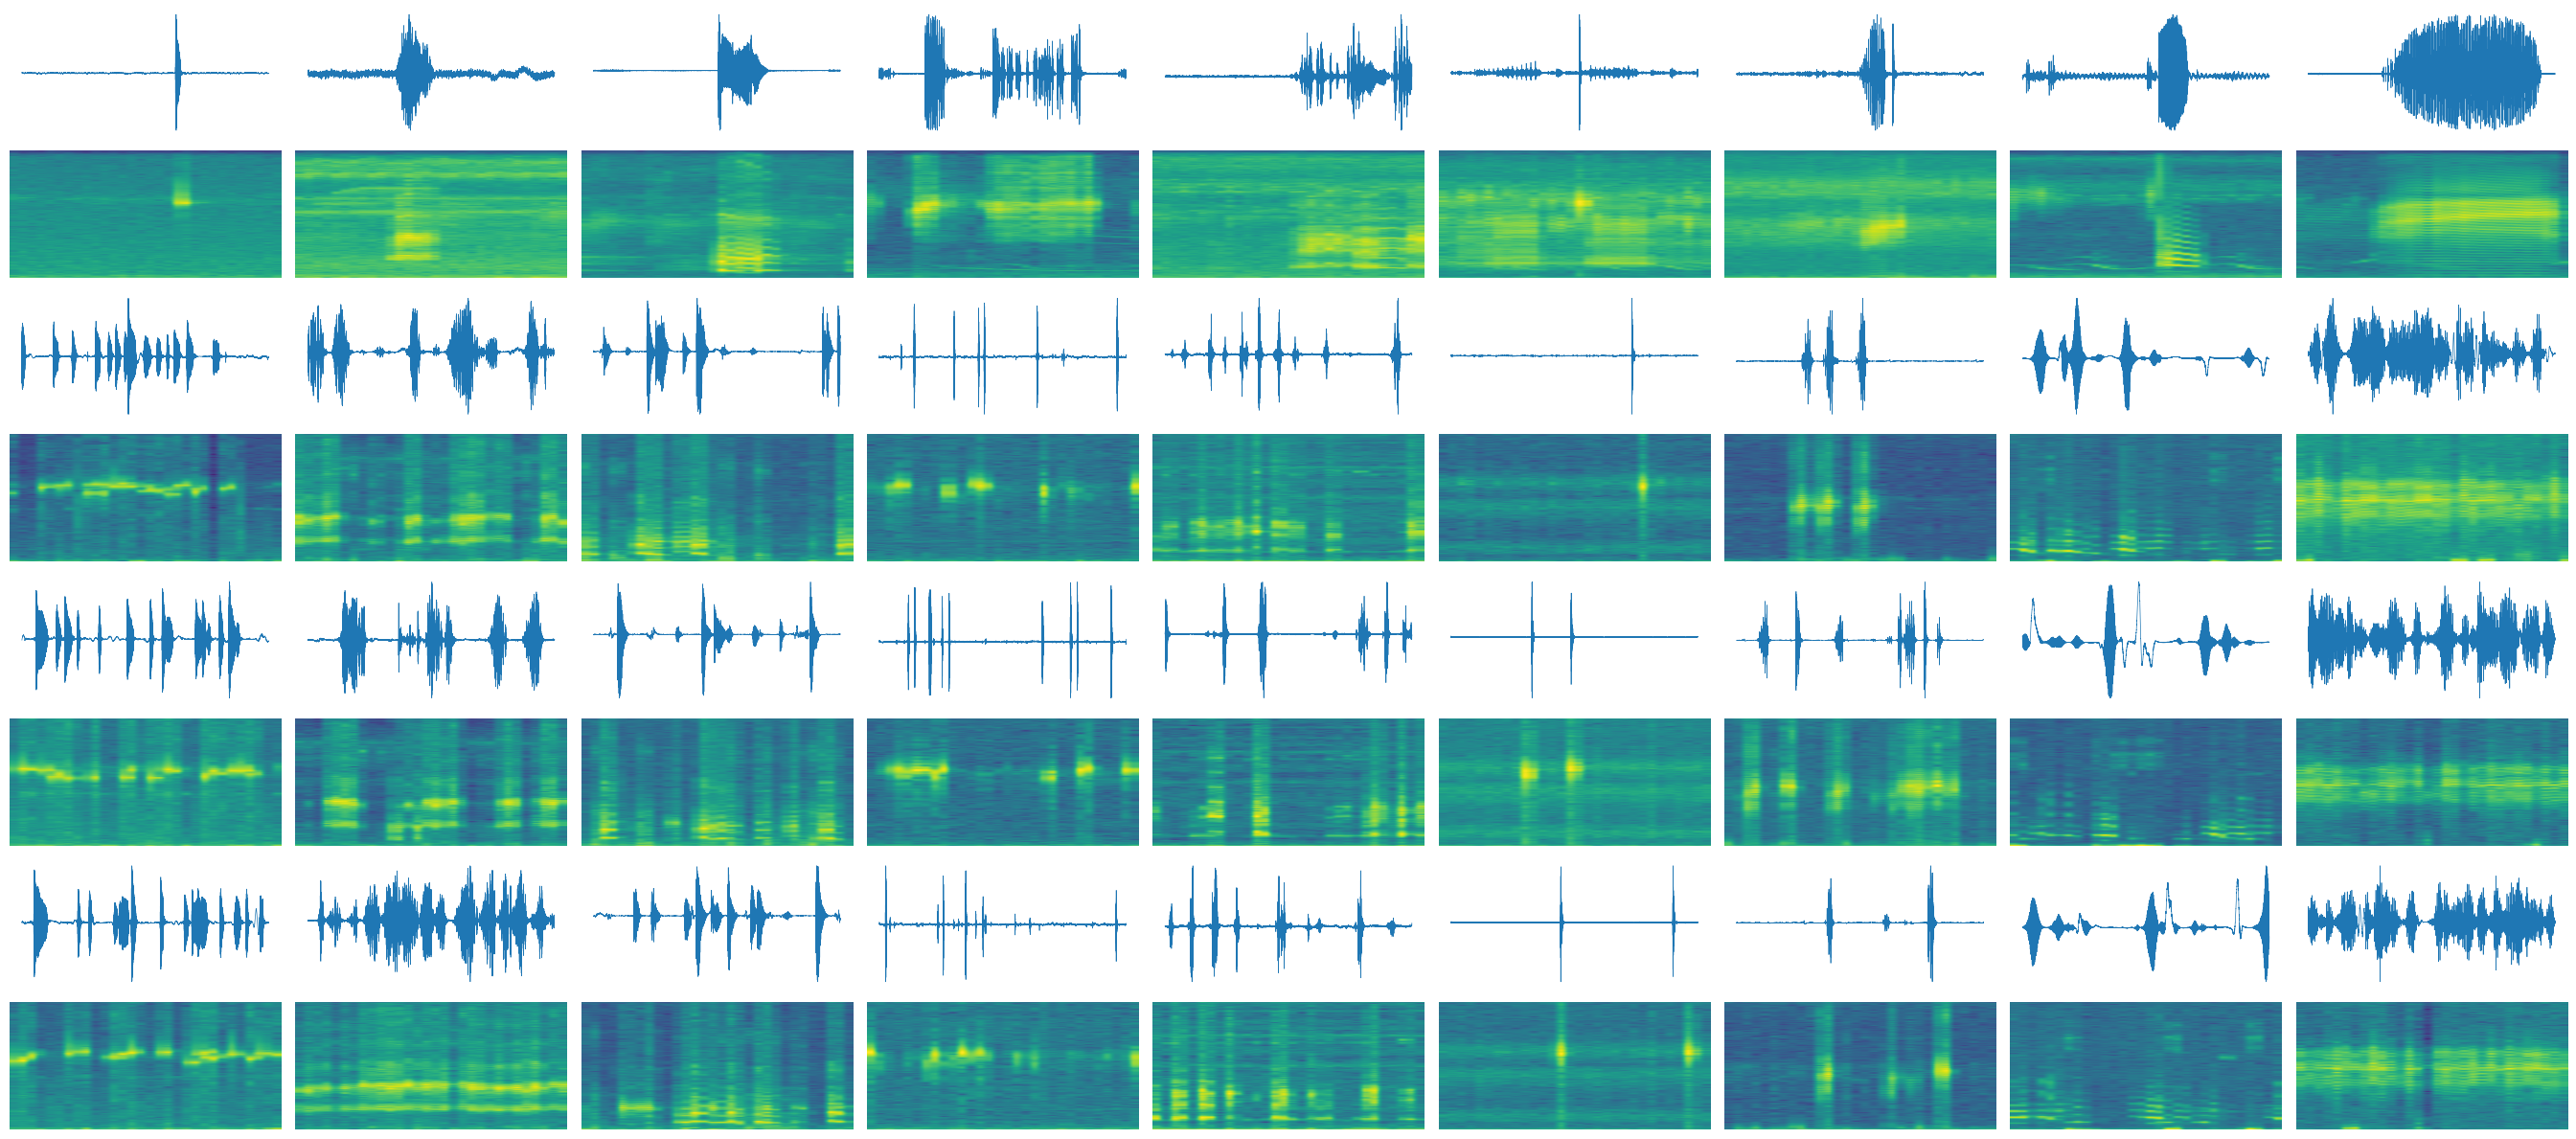

s1:
  real: 227_0_FNJV_0050734_Adenomera_marmorata_Paranapiacaba_SP_Ariovaldo A. Giaretta.wav
  generated: diffgen_audio_36.wav, diffgen_audio_116.wav, diffgen_audio_38.wav
s2:
  real: 803_0_FNJV_0043889_Boana_albomarginata_Picinguaba_SP_Guilherme Augusto-Alves.wav
  generated: diffgen_audio_33.wav, diffgen_audio_166.wav, diffgen_audio_15.wav
s3:
  real: 2617_0_FNJV_0032289_Boana_faber_Boraceia_SP_Lucas Rodriguez Forti.wav
  generated: diffgen_audio_72.wav, diffgen_audio_178.wav, diffgen_audio_26.wav
s4:
  real: 3495_0_FNJV_0030737_Boana_leptolineata_Lages_SC_Adao Jose Cardoso.wav
  generated: diffgen_audio_64.wav, diffgen_audio_117.wav, diffgen_audio_75.wav
s5:
  real: 1896_0_FNJV_0034120_Boana_raniceps_Aiuaba_CE_Diego Jose Santana.wav
  generated: diffgen_audio_84.wav, diffgen_audio_54.wav, diffgen_audio_31.wav
s6:
  real: 4067_0_1583-D.cruzi.wav
  generated: diffgen_audio_50.wav, diffgen_audio_30.wav, diffgen_audio_107.wav
s7:
  real: 2811_0_FNJV_0031672_Dendropsophus_elegans_Morret

In [79]:
import os
import random
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_wav_samples(dir1, dir2, n_samples=3):
    subdirs = sorted(d for d in os.listdir(dir1) if os.path.isdir(os.path.join(dir1, d)))
    n_cols = len(subdirs)
    n_rows = 2 + n_samples * 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 1.5))

    selection = {}

    # Primera muestra 'real'
    for col, subdir in enumerate(subdirs):
        path2_dir = os.path.join(dir2, subdir)
        files2 = [f for f in os.listdir(path2_dir) if f.lower().endswith('.wav')]
        real_file = random.choice(files2)
        selection.setdefault(subdir, {})['real'] = real_file
        sig2, sr2 = sf.read(os.path.join(path2_dir, real_file))
        times2 = np.linspace(0, len(sig2) / sr2, num=len(sig2))

        ax_wave = axes[0, col]
        ax_wave.plot(times2, sig2, linewidth=0.5)
        ax_wave.axis('off')

        ax_spec = axes[1, col]
        ax_spec.specgram(sig2, NFFT=1024, Fs=sr2, noverlap=512)
        ax_spec.axis('off')

    # Muestras 'generated'
    for col, subdir in enumerate(subdirs):
        path1_dir = os.path.join(dir1, subdir)
        files1 = [f for f in os.listdir(path1_dir) if f.lower().endswith('.wav')]
        gen_files = random.sample(files1, min(n_samples, len(files1)))
        selection[subdir]['generated'] = gen_files

        for i, fname in enumerate(gen_files):
            sig1, sr1 = sf.read(os.path.join(path1_dir, fname))
            times1 = np.linspace(0, len(sig1) / sr1, num=len(sig1))

            ax_wave = axes[2 + 2*i, col]
            ax_wave.plot(times1, sig1, linewidth=0.5)
            ax_wave.axis('off')

            ax_spec = axes[2 + 2*i + 1, col]
            ax_spec.specgram(sig1, NFFT=1024, Fs=sr1, noverlap=512)
            ax_spec.axis('off')

    plt.tight_layout()
    plt.show()

    # Imprimir selección
    for subdir, files in selection.items():
        print(f"{subdir}:")
        print("  real:", files['real'])
        print("  generated:", ", ".join(files['generated']))

# Uso
dir1 = 'C:/Users/user/Documents/soundDBAugmented/generated_by_diffusion/'
dir2 = 'C:/Users/user/Documents/soundDBAugmented/train_val_test_fulldb/train'
plot_comparison_wav_samples(dir1, dir2, n_samples=3)